# Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from catboost import CatBoostRegressor

In [2]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from lightgbm import LGBMRegressor
from sklearn import preprocessing

# Load Data

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
sample_submission_data=pd.read_csv("sample_submission.csv")
fulfilment_info_data = pd.read_csv("fulfilment_center_info.csv")
meal_info_data = pd.read_csv("meal_info.csv")

In [4]:
train_data.head(5)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [5]:
test_data.head(5)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [6]:
fulfilment_info_data.head(5)

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [7]:
meal_info_data.head(5)

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


# EDA

## Data Exploration

In [8]:
print("shape of train data",train_data.shape)

shape of train data (456548, 9)


In [9]:
print("shape of test data",test_data.shape)

shape of test data (32573, 8)


In [10]:
print("shape of fulfilment data",fulfilment_info_data.shape)

shape of fulfilment data (77, 5)


In [11]:
print("shape of meal data",meal_info_data.shape)

shape of meal data (51, 3)


In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
id                       456548 non-null int64
week                     456548 non-null int64
center_id                456548 non-null int64
meal_id                  456548 non-null int64
checkout_price           456548 non-null float64
base_price               456548 non-null float64
emailer_for_promotion    456548 non-null int64
homepage_featured        456548 non-null int64
num_orders               456548 non-null int64
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [13]:
fulfilment_info_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
center_id      77 non-null int64
city_code      77 non-null int64
region_code    77 non-null int64
center_type    77 non-null object
op_area        77 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.1+ KB


In [14]:
meal_info_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
meal_id     51 non-null int64
category    51 non-null object
cuisine     51 non-null object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


In [15]:
train_data.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000
mean,1.250096e+06,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760
std,1.443548e+05,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000
25%,1.124999e+06,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000
50%,1.250184e+06,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000
75%,1.375140e+06,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000
max,1.499999e+06,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000


In [16]:
fulfilment_info_data.describe()

,center_id,city_code,region_code,op_area
count,77.000000,77.000000,77.000000,77.000000
mean,83.142857,600.662338,56.493506,3.985714
std,46.090219,66.720274,18.126473,1.106406
min,10.000000,456.000000,23.000000,0.900000
25%,50.000000,553.000000,34.000000,3.500000
50%,77.000000,596.000000,56.000000,3.900000
75%,110.000000,651.000000,77.000000,4.400000
max,186.000000,713.000000,93.000000,7.000000


In [17]:
meal_info_data.describe()

,meal_id
count,51.000000
mean,2013.921569
std,553.633555
min,1062.000000
25%,1550.500000
50%,1971.000000
75%,2516.500000
max,2956.000000


### Merge the fields

In [18]:
train_data=pd.merge(train_data,fulfilment_info_data,on="center_id")
test_data=pd.merge(test_data,fulfilment_info_data,on="center_id")

train_data=pd.merge(train_data,meal_info_data,on="meal_id")
test_data=pd.merge(test_data,meal_info_data,on="meal_id")

In [19]:
train_data.head(5)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,TYPE_C,2.0,Beverages,Thai
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,TYPE_C,2.0,Beverages,Thai
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,TYPE_C,2.0,Beverages,Thai


In [20]:
test_data.head(5)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine
0,1028232,146,55,1885,158.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai
1,1262649,147,55,1885,159.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai
2,1453211,149,55,1885,157.14,158.14,0,0,647,56,TYPE_C,2.0,Beverages,Thai
3,1262599,150,55,1885,159.14,157.14,0,0,647,56,TYPE_C,2.0,Beverages,Thai
4,1495848,151,55,1885,160.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai


## Univariate Analysis

In [21]:
train_data.describe(include="all")

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000,456548.000000,456548.000000,456548,456548.000000,456548,456548
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,14,4
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TYPE_A,NaN,Beverages,Italian
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262881,NaN,127890,122925
mean,1.250096e+06,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760,601.553399,56.614566,NaN,4.083590,NaN,NaN
std,1.443548e+05,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798,66.195914,17.641306,NaN,1.091686,NaN,NaN
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000,456.000000,23.000000,NaN,0.900000,NaN,NaN
25%,1.124999e+06,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000,553.000000,34.000000,NaN,3.600000,NaN,NaN
50%,1.250184e+06,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000,596.000000,56.000000,NaN,4.000000,NaN,NaN
75%,1.375140e+06,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000,651.000000,77.000000,NaN,4.500000,NaN,NaN


C:\Users\abhay\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


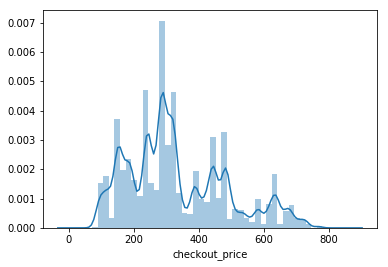

In [22]:
sns.distplot(train_data["checkout_price"])

C:\Users\abhay\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


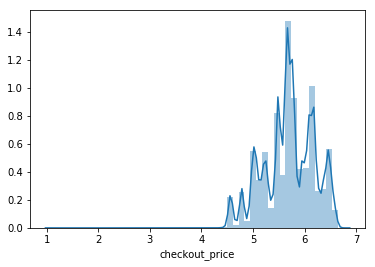

In [23]:
sns.distplot(np.log(train_data["checkout_price"]))
plt.show()

C:\Users\abhay\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


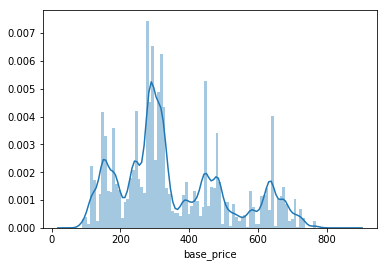

In [24]:
sns.distplot(train_data['base_price'],bins=100)

C:\Users\abhay\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


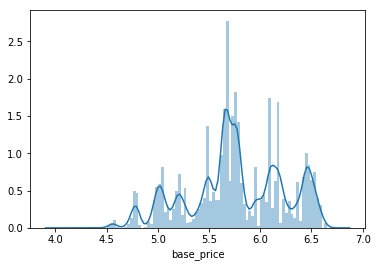

In [25]:
sns.distplot(np.log(train_data['base_price']),bins=100)

## Feature Engineering_1

In [26]:
train_data["discount value"]=train_data["checkout_price"]-train_data["base_price"]
train_data["discount percent"]=(train_data["checkout_price"]-train_data["base_price"])*100/train_data["base_price"]

test_data["discount value"]=test_data["checkout_price"]-test_data["base_price"]
test_data["discount percent"]=(test_data["checkout_price"]-test_data["base_price"])*100/test_data["base_price"]

train_data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,discount value,discount percent
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai,-15.46,-10.151684
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai,-16.46,-10.808326
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,TYPE_C,2.0,Beverages,Thai,-1.00,-0.746714
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,TYPE_C,2.0,Beverages,Thai,1.00,0.741510
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,TYPE_C,2.0,Beverages,Thai,-1.00,-0.677966


Checkout Price > base price - only if taxes + delivery fees exceeds the discount provided. Assuming tax percent is uniform across the states, then this is possible only when delivery fees > discounts

Main question - Is this related to number of orders? - If delivery fees is too high then customer won't place the order

Discount is negative for transactions - which means that the Selling price was less than the cost price(base price) - the client will have to bear the loss for this

Discount was positive for few transations - client made profit on these basically due to high delivery fees

From this we can figure out - on which center and/or which meal we are giving discount and on which ones we are profitable
This can be useful in product line analysis

Same can be extended to emailer_for_promotion and homepage_featured - is having this leading to more profitability or not

#### We can take this up later

In [27]:
train_data["discount value"].describe()

count    456548.000000
mean        -21.917695
std          48.495857
min        -561.600000
25%         -16.520000
50%          -1.000000
75%           1.000000
max         185.300000
Name: discount value, dtype: float64

In [28]:
train_data["discount(yes/no)"] = train_data["discount value"].apply(lambda x:1 if x<0 else 0)
test_data["discount(yes/no)"] = test_data["discount value"].apply(lambda x:1 if x<0 else 0)
train_data.head(10)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,discount value,discount percent,discount(yes/no)
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai,-15.46,-10.151684,1
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai,-16.46,-10.808326,1
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,TYPE_C,2.0,Beverages,Thai,-1.00,-0.746714,1
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,TYPE_C,2.0,Beverages,Thai,1.00,0.741510,0
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,TYPE_C,2.0,Beverages,Thai,-1.00,-0.677966,1
5,1493612,6,55,1885,146.53,146.53,0,0,285,647,56,TYPE_C,2.0,Beverages,Thai,0.00,0.000000,0
6,1110832,7,55,1885,145.53,146.53,0,0,148,647,56,TYPE_C,2.0,Beverages,Thai,-1.00,-0.682454,1
7,1461167,8,55,1885,146.53,145.53,0,0,135,647,56,TYPE_C,2.0,Beverages,Thai,1.00,0.687144,0
8,1102364,9,55,1885,134.83,134.83,0,0,175,647,56,TYPE_C,2.0,Beverages,Thai,0.00,0.000000,0
9,1018130,10,55,1885,144.56,143.56,0,0,175,647,56,TYPE_C,2.0,Beverages,Thai,1.00,0.696573,0


In [29]:
test_data.head(10)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine,discount value,discount percent,discount(yes/no)
0,1028232,146,55,1885,158.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,-1.0,-0.628496,1
1,1262649,147,55,1885,159.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,0.0,0.000000,0
2,1453211,149,55,1885,157.14,158.14,0,0,647,56,TYPE_C,2.0,Beverages,Thai,-1.0,-0.632351,1
3,1262599,150,55,1885,159.14,157.14,0,0,647,56,TYPE_C,2.0,Beverages,Thai,2.0,1.272750,0
4,1495848,151,55,1885,160.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,1.0,0.628496,0
5,1342607,152,55,1885,159.11,160.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,-1.0,-0.624571,1
6,1358429,153,55,1885,159.11,158.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,1.0,0.632471,0
7,1475006,154,55,1885,160.11,158.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,2.0,1.264942,0
8,1009709,155,55,1885,158.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,-1.0,-0.628496,1
9,1460444,146,24,1885,158.11,160.11,0,1,614,85,TYPE_B,3.6,Beverages,Thai,-2.0,-1.249141,1


C:\Users\abhay\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


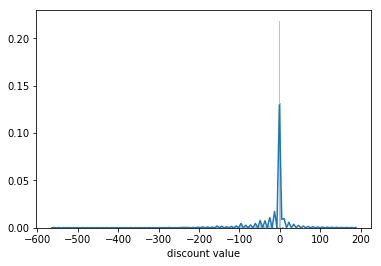

In [30]:
sns.distplot(train_data["discount value"],bins=400)

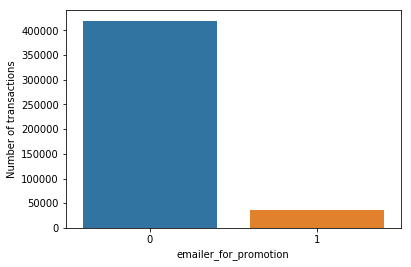

In [31]:
ax=sns.countplot(train_data["emailer_for_promotion"])
ax.set(ylabel="Number of transactions")
plt.show()

Only for 37050 transactions email was sent for promotions.
#### Need to do Bivariate to deep dive into this

In [32]:
train_data.groupby(["emailer_for_promotion"]).count().id

emailer_for_promotion
0    419498
1     37050
Name: id, dtype: int64

In [33]:
train_data.groupby(["homepage_featured"]).count().id

homepage_featured
0    406693
1     49855
Name: id, dtype: int64

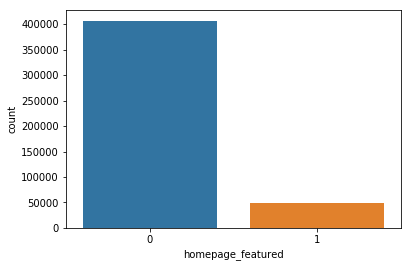

In [34]:
sns.countplot(train_data["homepage_featured"])

Only for 49855 transactions the meal was featured in the homepage

Need to do Bivariate to deep dive into this

C:\Users\abhay\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


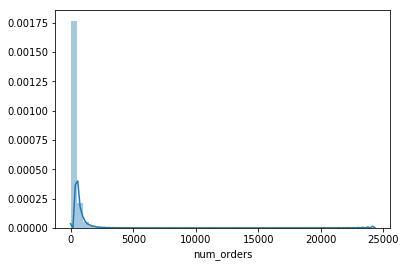

In [35]:
sns.distplot(train_data["num_orders"])

##### The target variable is highly skewed - hence advised to do log transformation

In [36]:
train_data["num_orders"].describe()

count    456548.000000
mean        261.872760
std         395.922798
min          13.000000
25%          54.000000
50%         136.000000
75%         324.000000
max       24299.000000
Name: num_orders, dtype: float64

C:\Users\abhay\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


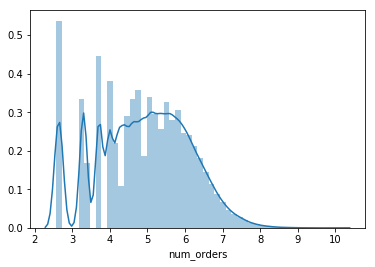

In [37]:
sns.distplot(np.log(train_data['num_orders']))

## Feature Engineering_2

In [38]:
train_data["num_orders_transformed"]=np.log(train_data['num_orders'])
train_data["checkout_price_transformed"]=np.log(train_data['checkout_price'])
train_data["base_price_transformed"]=np.log(train_data['base_price'])

test_data["checkout_price_transformed"]=np.log(test_data['checkout_price'])
test_data["base_price_transformed"]=np.log(test_data['base_price'])

train_data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,center_type,op_area,category,cuisine,discount value,discount percent,discount(yes/no),num_orders_transformed,checkout_price_transformed,base_price_transformed
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,...,TYPE_C,2.0,Beverages,Thai,-15.46,-10.151684,1,5.176150,4.918739,5.025787
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,...,TYPE_C,2.0,Beverages,Thai,-16.46,-10.808326,1,5.777652,4.911404,5.025787
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,...,TYPE_C,2.0,Beverages,Thai,-1.00,-0.746714,1,4.564348,4.889747,4.897243
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,...,TYPE_C,2.0,Beverages,Thai,1.00,0.741510,0,5.093750,4.911625,4.904237
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,...,TYPE_C,2.0,Beverages,Thai,-1.00,-0.677966,1,5.370638,4.987025,4.993828


In [39]:
test_data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine,discount value,discount percent,discount(yes/no),checkout_price_transformed,base_price_transformed
0,1028232,146,55,1885,158.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,-1.0,-0.628496,1,5.063291,5.069596
1,1262649,147,55,1885,159.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,0.0,0.000000,0,5.069596,5.069596
2,1453211,149,55,1885,157.14,158.14,0,0,647,56,TYPE_C,2.0,Beverages,Thai,-1.0,-0.632351,1,5.057137,5.063481
3,1262599,150,55,1885,159.14,157.14,0,0,647,56,TYPE_C,2.0,Beverages,Thai,2.0,1.272750,0,5.069784,5.057137
4,1495848,151,55,1885,160.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,1.0,0.628496,0,5.075861,5.069596


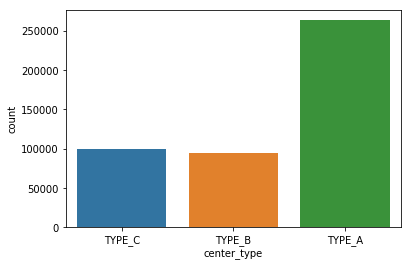

In [40]:
sns.countplot(train_data["center_type"])

In [41]:
train_data.groupby(["center_type"]).count().id

center_type
TYPE_A    262881
TYPE_B     94074
TYPE_C     99593
Name: id, dtype: int64

C:\Users\abhay\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


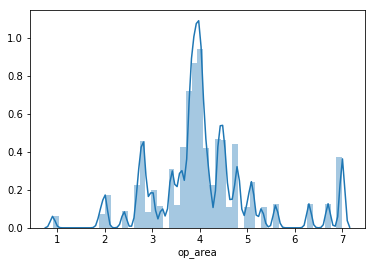

In [42]:
sns.distplot(train_data["op_area"])

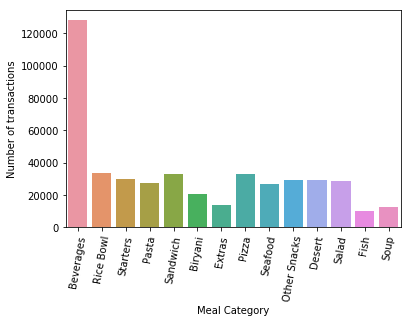

In [43]:
ax=sns.countplot(train_data["category"])
plt.xticks(rotation=80)
ax.set(ylabel="Number of transactions")
ax.set(xlabel="Meal Category")
plt.show()

In [44]:
train_data.groupby(["category"]).count().id

category
Beverages       127890
Biryani          20614
Desert           29294
Extras           13562
Fish             10187
Other Snacks     29379
Pasta            27694
Pizza            33138
Rice Bowl        33408
Salad            28559
Sandwich         33291
Seafood          26916
Soup             12675
Starters         29941
Name: id, dtype: int64

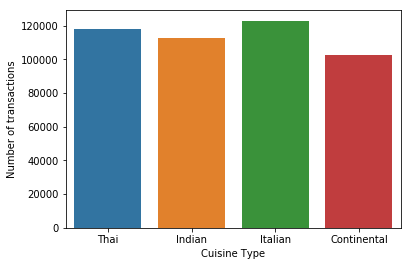

In [45]:
ax=sns.countplot(train_data["cuisine"])
ax.set(ylabel="Number of transactions")
ax.set(xlabel="Cuisine Type")
plt.show()

In [46]:
train_data.groupby(["cuisine"]).count().id

cuisine
Continental    102795
Indian         112612
Italian        122925
Thai           118216
Name: id, dtype: int64

## Bivariate Analysis

In [47]:
train_year1=train_data[train_data["week"]<=52]
week_order=train_year1.groupby("week").num_orders.sum().to_frame().reset_index()
week_order.head()

,week,num_orders
0,1,792261
1,2,787084
2,3,695262
3,4,743529
4,5,1198675


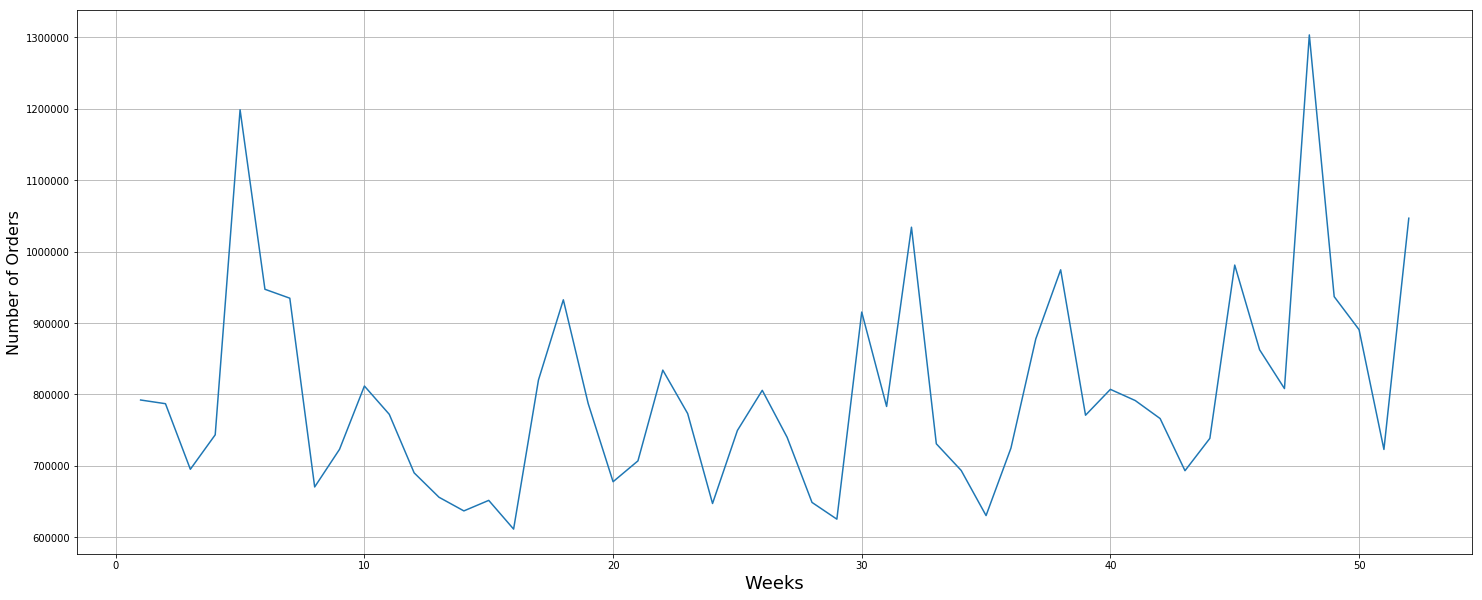

In [48]:
plt.figure(figsize=(25,10))
sns.lineplot(week_order["week"],week_order["num_orders"])
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Number of Orders', fontsize=16)
plt.grid(True)
plt.show()

No consistent pattern can be seen - but it can be observed that cyclicity/seasonality exists.
Let's try for 2 years and see if the pattern repeats itself

##### Need to take lags

In [49]:
train_year2=train_data[(train_data["week"]>52) & (train_data["week"]<=104)]
week_order2=train_year2.groupby("week").num_orders.sum().to_frame().reset_index()
week_order2.head()

,week,num_orders
0,53,1108236
1,54,757268
2,55,875145
3,56,843250
4,57,916721


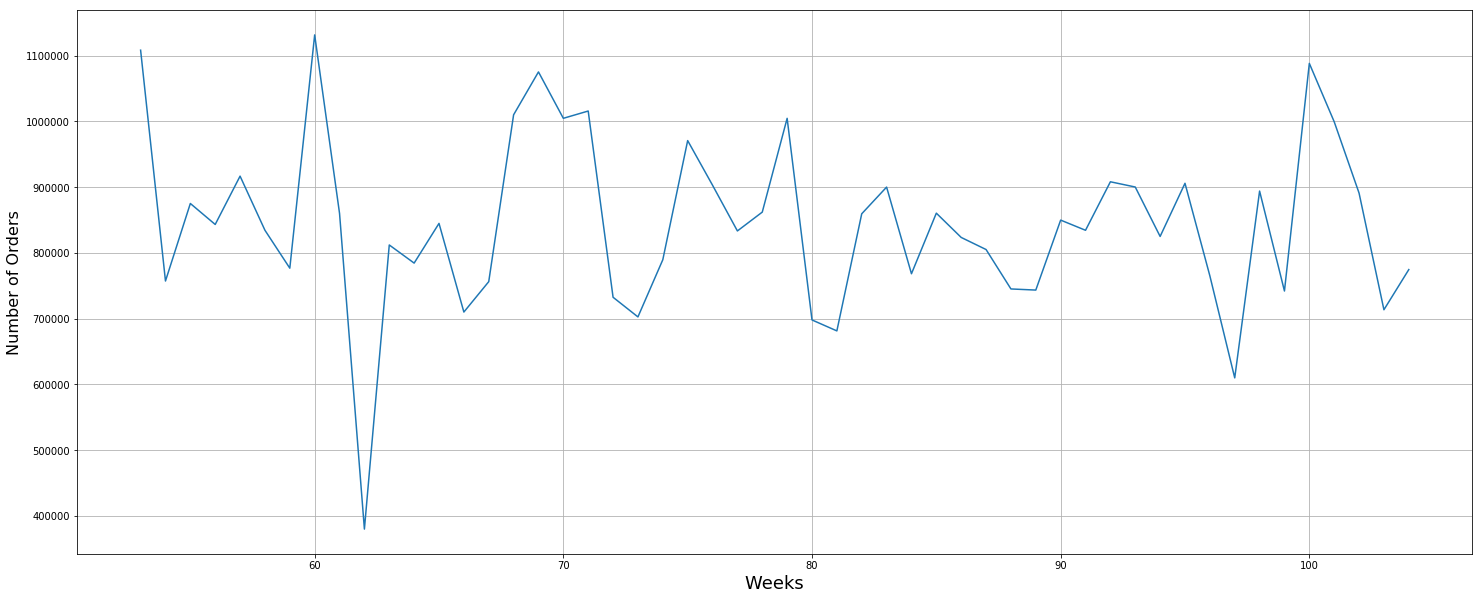

In [50]:
plt.figure(figsize=(25,10))
sns.lineplot(week_order2["week"],week_order2["num_orders"])
plt.xlabel('Weeks', fontsize=18)
plt.ylabel('Number of Orders', fontsize=16)
plt.grid(True)
plt.show()

In [51]:
abc=train_data.pivot_table("num_orders","center_type","cuisine",aggfunc="sum")
abc

cuisine,Continental,Indian,Italian,Thai
center_type,,,,
TYPE_A,9874117,14512558,24778761,19813081
TYPE_B,3559456,6944518,9939385,9552714
TYPE_C,3480866,4335468,9454686,3311875


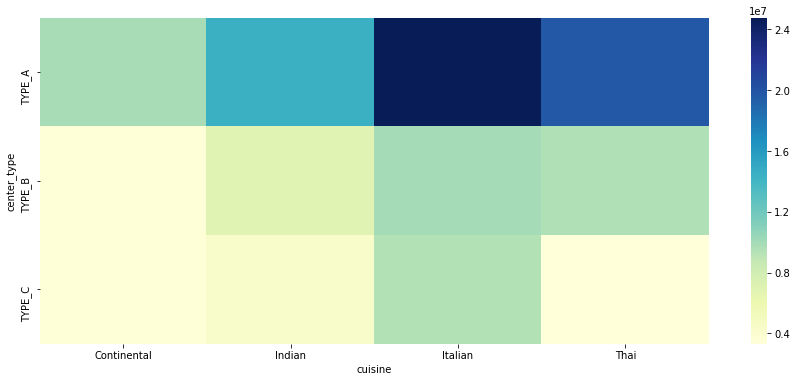

In [52]:
plt.figure(figsize=(15,6))
sns.heatmap(abc,cmap="YlGnBu")

In [53]:
abc=train_data.pivot_table("num_orders","center_type","category",aggfunc="sum")
abc

category,Beverages,Biryani,Desert,Extras,Fish,Other Snacks,Pasta,Pizza,Rice Bowl,Salad,Sandwich,Seafood,Soup,Starters
center_type,,,,,,,,,,,,,,
TYPE_A,24633857,348112,1006575,2385158,468892,2721316,893619,4178759,11847850,5773622,9844003,1624714,612597,2639443
TYPE_B,9340360,228273,597142,1251120,375444,1755359,530987,1585932,5519104,2269206,3760525,790897,296544,1695180
TYPE_C,6506308,55463,337037,348701,27623,289618,213138,1619029,3507109,2901508,4032254,300103,130505,314499


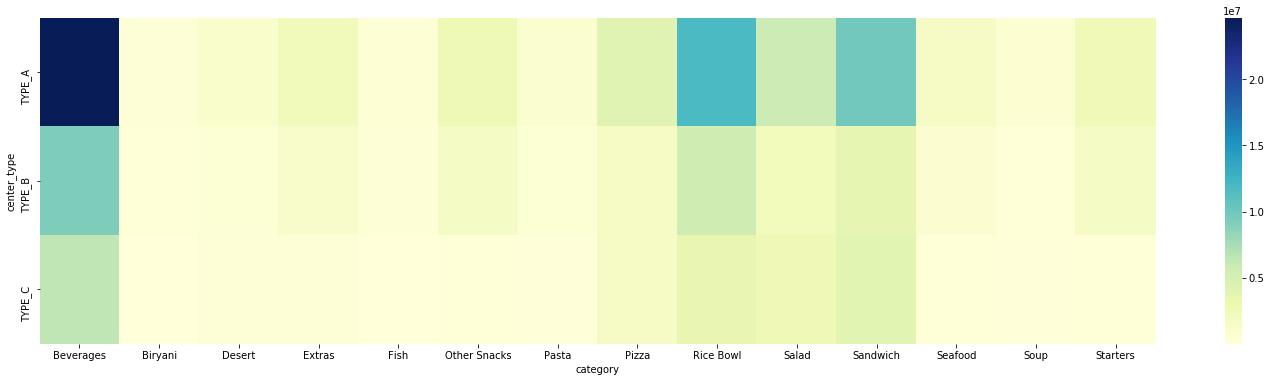

In [54]:
plt.figure(figsize=(25,6))
sns.heatmap(abc,cmap="YlGnBu")

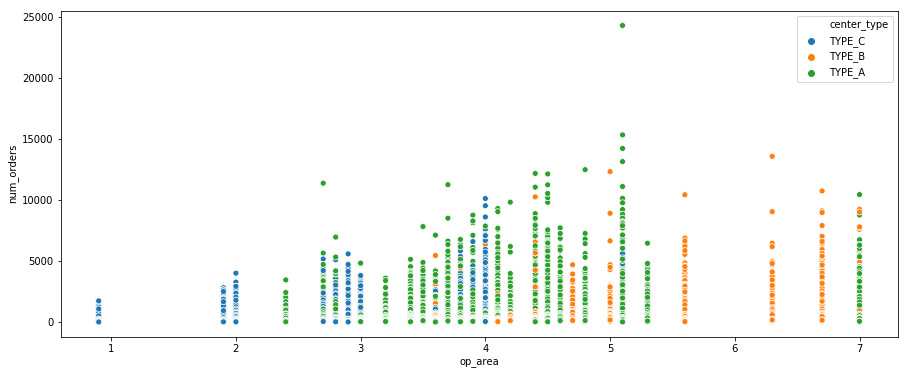

In [55]:
plt.figure(figsize=(15,6))
sns.scatterplot(train_data["op_area"],train_data["num_orders"],hue=train_data["center_type"])
plt.show()

Correlation between these 2 variable seems to be low

In [56]:
train_data["op_area"].corr(train_data["num_orders"])

0.1769762880230972

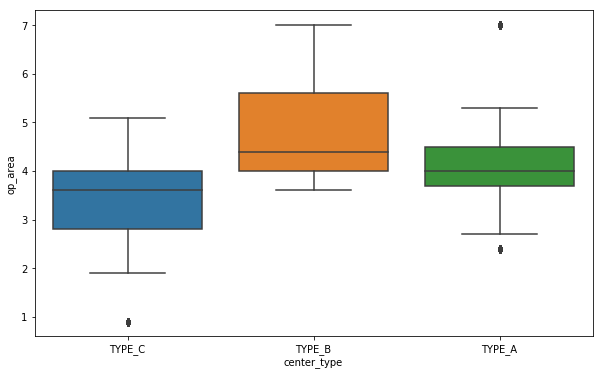

In [57]:
plt.figure(figsize=(10,6))
sns.boxplot(train_data["center_type"],train_data["op_area"])
plt.show()

Type B has a higher operational area than others --> is this leading to more orders?? 
No, A has the maximum number of orders --> Is there any significant difference? 
##### Do Anova to confirm

In [58]:
train_data.groupby(["center_type"]).sum().num_orders

center_type
TYPE_A    68978517
TYPE_B    29996073
TYPE_C    20582895
Name: num_orders, dtype: int64

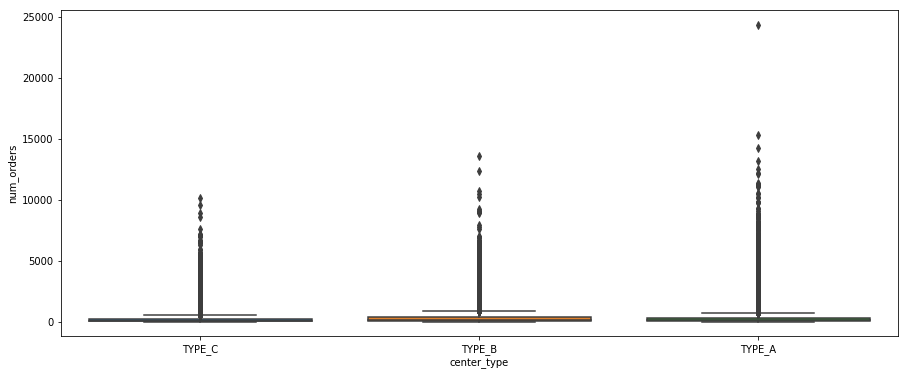

In [59]:
plt.figure(figsize=(15,6))
sns.boxplot(train_data["center_type"],train_data["num_orders"])
plt.show()

Confirmed the existence of Outliers

In [60]:
region_order=train_data.groupby("region_code").num_orders.sum().to_frame().reset_index()
region_order.head(10)

,region_code,num_orders
0,23,1609906
1,34,24051733
2,35,691044
3,56,60520191
4,71,2103282
5,77,20529653
6,85,8685386
7,93,1366290


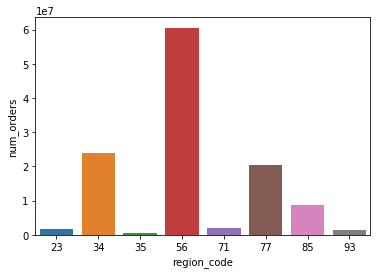

In [61]:
#region vs num_orders
sns.barplot(region_order["region_code"],region_order["num_orders"])
plt.show()
# Do per store

In [62]:
abc=train_data.pivot_table("num_orders","region_code","center_type",aggfunc="sum")
abc

center_type,TYPE_A,TYPE_B,TYPE_C
region_code,,,
23,1609906.0,NaN,NaN
34,12209875.0,6266222.0,5575636.0
35,691044.0,NaN,NaN
56,34843144.0,17894183.0,7782864.0
71,2103282.0,NaN,NaN
77,12688539.0,3838133.0,4002981.0
85,3466437.0,1997535.0,3221414.0
93,1366290.0,NaN,NaN


In [63]:
region_order=pd.merge(region_order,abc,on="region_code")
region_order

,region_code,num_orders,TYPE_A,TYPE_B,TYPE_C
0,23,1609906,1609906.0,NaN,NaN
1,34,24051733,12209875.0,6266222.0,5575636.0
2,35,691044,691044.0,NaN,NaN
3,56,60520191,34843144.0,17894183.0,7782864.0
4,71,2103282,2103282.0,NaN,NaN
5,77,20529653,12688539.0,3838133.0,4002981.0
6,85,8685386,3466437.0,1997535.0,3221414.0
7,93,1366290,1366290.0,NaN,NaN


In [64]:
region_order["TYPE_A %"]=region_order["TYPE_A"]*100/region_order["num_orders"]
region_order["TYPE_B %"]=region_order["TYPE_B"]*100/region_order["num_orders"]
region_order["TYPE_C %"]=region_order["TYPE_C"]*100/region_order["num_orders"]
region_order

,region_code,num_orders,TYPE_A,TYPE_B,TYPE_C,TYPE_A %,TYPE_B %,TYPE_C %
0,23,1609906,1609906.0,NaN,NaN,100.000000,NaN,NaN
1,34,24051733,12209875.0,6266222.0,5575636.0,50.765053,26.053100,23.181847
2,35,691044,691044.0,NaN,NaN,100.000000,NaN,NaN
3,56,60520191,34843144.0,17894183.0,7782864.0,57.572759,29.567294,12.859946
4,71,2103282,2103282.0,NaN,NaN,100.000000,NaN,NaN
5,77,20529653,12688539.0,3838133.0,4002981.0,61.805911,18.695557,19.498532
6,85,8685386,3466437.0,1997535.0,3221414.0,39.911145,22.998805,37.090050
7,93,1366290,1366290.0,NaN,NaN,100.000000,NaN,NaN


In [65]:
region_order.TYPE_C.sum()*100/region_order.num_orders.sum()

17.21589827688329

Region 23,35,71 and 93 has only Type A fulfillment center. Region 34, 56, 77 and 85 has all the 3 types of centers.
Overall 57.7% of the total orders are coming from Type A fulfillment center,
25% of the total orders are coming from Type B fulfillment center
17.21% of the total orders are coming from Type C fulfillment center

In [66]:
count_center=fulfilment_info_data.groupby(["region_code"]).center_id.count().to_frame().reset_index()
count_center.rename(columns={"center_id":"center_count"})

,region_code,center_count
0,23,1
1,34,21
2,35,1
3,56,30
4,71,1
5,77,17
6,85,5
7,93,1


In [67]:
region_center=pd.merge(region_order,count_center,on="region_code")
region_center

,region_code,num_orders,TYPE_A,TYPE_B,TYPE_C,TYPE_A %,TYPE_B %,TYPE_C %,center_id
0,23,1609906,1609906.0,NaN,NaN,100.000000,NaN,NaN,1
1,34,24051733,12209875.0,6266222.0,5575636.0,50.765053,26.053100,23.181847,21
2,35,691044,691044.0,NaN,NaN,100.000000,NaN,NaN,1
3,56,60520191,34843144.0,17894183.0,7782864.0,57.572759,29.567294,12.859946,30
4,71,2103282,2103282.0,NaN,NaN,100.000000,NaN,NaN,1
5,77,20529653,12688539.0,3838133.0,4002981.0,61.805911,18.695557,19.498532,17
6,85,8685386,3466437.0,1997535.0,3221414.0,39.911145,22.998805,37.090050,5
7,93,1366290,1366290.0,NaN,NaN,100.000000,NaN,NaN,1


In [68]:
region_center["order per center"]=region_center["num_orders"]/region_center["center_id"]
region_center

,region_code,num_orders,TYPE_A,TYPE_B,TYPE_C,TYPE_A %,TYPE_B %,TYPE_C %,center_id,order per center
0,23,1609906,1609906.0,NaN,NaN,100.000000,NaN,NaN,1,1.609906e+06
1,34,24051733,12209875.0,6266222.0,5575636.0,50.765053,26.053100,23.181847,21,1.145321e+06
2,35,691044,691044.0,NaN,NaN,100.000000,NaN,NaN,1,6.910440e+05
3,56,60520191,34843144.0,17894183.0,7782864.0,57.572759,29.567294,12.859946,30,2.017340e+06
4,71,2103282,2103282.0,NaN,NaN,100.000000,NaN,NaN,1,2.103282e+06
5,77,20529653,12688539.0,3838133.0,4002981.0,61.805911,18.695557,19.498532,17,1.207627e+06
6,85,8685386,3466437.0,1997535.0,3221414.0,39.911145,22.998805,37.090050,5,1.737077e+06
7,93,1366290,1366290.0,NaN,NaN,100.000000,NaN,NaN,1,1.366290e+06


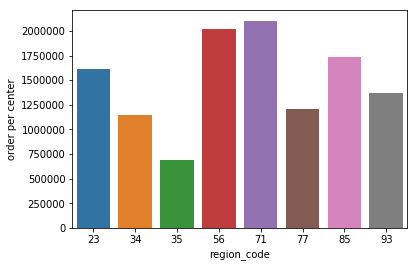

In [69]:
sns.barplot(region_center["region_code"],region_center["order per center"])
plt.show()

#### This indicates that region 71, 56, 85 are the top 3 regions of the client

# Statistical Tests

In [70]:
## Subset the continuous data on which statistical test can be done
subset_train=train_data[["checkout_price","base_price","op_area","discount value","num_orders",]]
subset_train.head()

,checkout_price,base_price,op_area,discount value,num_orders
0,136.83,152.29,2.0,-15.46,177
1,135.83,152.29,2.0,-16.46,323
2,132.92,133.92,2.0,-1.00,96
3,135.86,134.86,2.0,1.00,163
4,146.50,147.50,2.0,-1.00,215


In [71]:
corr = subset_train.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,checkout_price,base_price,op_area,discount value,num_orders
checkout_price,1,0.95,0.022,-0.0059,-0.28
base_price,0.95,1,0.018,-0.31,-0.22
op_area,0.022,0.018,1,0.0083,0.18
discount value,-0.0059,-0.31,0.0083,1,-0.15
num_orders,-0.28,-0.22,0.18,-0.15,1


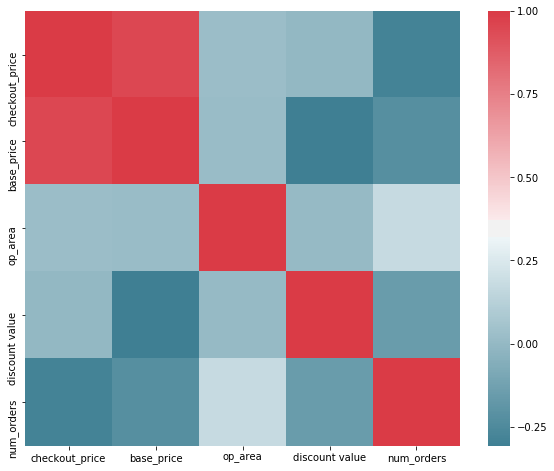

In [72]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

From the analysis of continuous variables, we can conclude that checkout_price,base_price,op_area and discount value all have almost similar correlation with the Number of orders. Thus, we need to take all these into consideration in the final model
#### confirming the same with log transformation

In [73]:
subset_train=train_data[["checkout_price_transformed","base_price_transformed","op_area","discount value","num_orders_transformed",]]
subset_train.head()

,checkout_price_transformed,base_price_transformed,op_area,discount value,num_orders_transformed
0,4.918739,5.025787,2.0,-15.46,5.176150
1,4.911404,5.025787,2.0,-16.46,5.777652
2,4.889747,4.897243,2.0,-1.00,4.564348
3,4.911625,4.904237,2.0,1.00,5.093750
4,4.987025,4.993828,2.0,-1.00,5.370638


In [74]:
corr = subset_train.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,checkout_price_transformed,base_price_transformed,op_area,discount value,num_orders_transformed
checkout_price_transformed,1,0.96,0.023,-0.014,-0.38
base_price_transformed,0.96,1,0.021,-0.28,-0.34
op_area,0.023,0.021,1,0.0083,0.2
discount value,-0.014,-0.28,0.0083,1,-0.14
num_orders_transformed,-0.38,-0.34,0.2,-0.14,1


#### Test if the orders from Each Center_Type is significantly different - This will confirm if Center_Type plays a role in generating orders

In [75]:
stats.f_oneway(train_data[train_data["center_type"]=="TYPE_A"].num_orders,
               train_data[train_data["center_type"]=="TYPE_B"].num_orders,
               train_data[train_data["center_type"]=="TYPE_C"].num_orders)

F_onewayResult(statistic=1959.2938339271484, pvalue=0.0)

p value<5% meaning there is a significant difference between the order placed from the 3 center type - this is a significant variable

In [76]:
mc = MultiComparison(train_data['num_orders'], train_data['center_type'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff   lower     upper   reject
-------------------------------------------------
TYPE_A TYPE_B 56.4617   52.9513   59.9721   True 
TYPE_A TYPE_C -55.7244  -59.1623  -52.2864  True 
TYPE_B TYPE_C -112.186 -116.3869 -107.9852  True 
-------------------------------------------------
['TYPE_A' 'TYPE_B' 'TYPE_C']


#### Test if the orders from Each meal category is significantly different - This will confirm if meal category plays a role in generating orders

In [77]:
f, p =stats.f_oneway(train_data[train_data["category"]=="Beverages"].num_orders,
               train_data[train_data["category"]=="Rice Bowl"].num_orders,
               train_data[train_data["category"]=="Starters"].num_orders,
               train_data[train_data["category"]=="Pasta"].num_orders,
               train_data[train_data["category"]=="Starters"].num_orders,               
               train_data[train_data["category"]=="Sandwich"].num_orders,
               train_data[train_data["category"]=="Biryani"].num_orders,
               train_data[train_data["category"]=="Extras"].num_orders,
               train_data[train_data["category"]=="Pizza"].num_orders,
               train_data[train_data["category"]=="Seafood"].num_orders,
               train_data[train_data["category"]=="Other Snacks"].num_orders,
               train_data[train_data["category"]=="Desert"].num_orders,               
               train_data[train_data["category"]=="Salad"].num_orders,
               train_data[train_data["category"]=="Fish"].num_orders,
               train_data[train_data["category"]=="Soup"].num_orders)
print ('One-way ANOVA')
print ('=============')
 
print ('F value:', f)
print ('P value:', p, '\n')

mc = MultiComparison(train_data['num_orders'], train_data['category'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 7878.556654621675
P value: 0.0 

      Multiple Comparison of Means - Tukey HSD,FWER=0.05      
   group1       group2     meandiff   lower     upper   reject
--------------------------------------------------------------
 Beverages     Biryani    -285.8747 -294.8845  -276.865  True 
 Beverages      Desert    -250.2752 -258.0509 -242.4995  True 
 Beverages      Extras     -22.6919  -33.5329  -11.851   True 
 Beverages       Fish     -230.9308 -243.2893 -218.5724  True 
 Beverages   Other Snacks -154.2914  -162.058 -146.5249  True 
 Beverages      Pasta      -257.389 -265.3453 -249.4326  True 
 Beverages      Pizza      -93.7088 -101.1085  -86.3091  True 
 Beverages    Rice Bowl    308.2962  300.9203  315.6721  True 
 Beverages      Salad      66.6923   58.8357    74.549   True 
 Beverages     Sandwich    213.2502  205.864   220.6363  True 
 Beverages     Seafood    -215.6302 -223.6805 -207.5799  True 
 Beverages       Soup     -234.5028 -245.6814 -223.3241  True 

There is a significant difference between the order placed for different category of meal - this is a significant variable. 
Exception - No difference between -(Other Snacks,Starters), (Fish,Soup), (Desert, Pasta)

#### Test if the orders from Each cuisine type is significantly different - This will confirm if cuisine plays a role in generating orders

In [78]:
f, p =stats.f_oneway(train_data[train_data["cuisine"]=="Thai"].num_orders,
               train_data[train_data["cuisine"]=="Indian"].num_orders,
               train_data[train_data["cuisine"]=="Italian"].num_orders,
               train_data[train_data["cuisine"]=="Continental"].num_orders)
print ('One-way ANOVA')
print ('=============')
 
print ('F value:', f)
print ('P value:', p, '\n')

mc = MultiComparison(train_data['num_orders'], train_data['cuisine'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 5026.286988085112
P value: 0.0 

  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
   group1    group2 meandiff  lower    upper   reject
-----------------------------------------------------
Continental  Indian 64.4937  60.1768  68.8106   True 
Continental Italian 194.8025 190.5728 199.0321  True 
Continental   Thai  111.8781 107.6102 116.1459  True 
   Indian   Italian 130.3088 126.1808 134.4368  True 
   Indian     Thai  47.3844  43.2172  51.5515   True 
  Italian     Thai  -82.9244 -87.0011 -78.8478  True 
-----------------------------------------------------
['Continental' 'Indian' 'Italian' 'Thai']


There is a significant difference between the order placed for different cuisines - this is a significant variable

#### Test if email plays any role in generating more orders 

In [79]:
f, p =stats.f_oneway(train_data[train_data["emailer_for_promotion"]==0].num_orders,
               train_data[train_data["emailer_for_promotion"]==1].num_orders)
print ('One-way ANOVA')
print ('=============')
 
print ('F value:', f)
print ('P value:', p, '\n')

mc = MultiComparison(train_data['num_orders'], train_data['emailer_for_promotion'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 37985.125874680794
P value: 0.0 

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper   reject
-----------------------------------------------
  0      1    401.8347 397.7937 405.8757  True 
-----------------------------------------------
[0 1]


There is a significant difference between the order placed with and without email - this is a significant variable.
Average Order place with email>Average order place without email

#### Test if homepage featuring of a meal plays any role in generating more orders

In [81]:
f, p =stats.f_oneway(train_data[train_data["homepage_featured"]==0].num_orders,
               train_data[train_data["homepage_featured"]==1].num_orders)
print ('One-way ANOVA')
print ('=============')
 
print ('F value:', f)
print ('P value:', p, '\n')

mc = MultiComparison(train_data['num_orders'], train_data['homepage_featured'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 43353.535673791324
P value: 0.0 

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper   reject
-----------------------------------------------
  0      1    373.8347 370.3158 377.3537  True 
-----------------------------------------------
[0 1]


In [80]:
stats.ttest_ind(train_data[train_data["homepage_featured"]==0].num_orders,
               train_data[train_data["homepage_featured"]==1].num_orders)

Ttest_indResult(statistic=-208.21511874451218, pvalue=0.0)

There is a significant difference between the order placed with and without homepage featuring - this is a significant variable. Average Order placed for homepage feature cuisines>Average order placed for homepage feature cuisines

#### Test if discount on a meal plays any role in generating more orders

In [82]:
f, p =stats.f_oneway(train_data[train_data["discount(yes/no)"]==0].num_orders,
               train_data[train_data["discount(yes/no)"]==1].num_orders)
print ('One-way ANOVA')
print ('=============')
 
print ('F value:', f)
print ('P value:', p, '\n')

mc = MultiComparison(train_data['num_orders'], train_data['discount(yes/no)'])
result = mc.tukeyhsd()
 
print(result)
print(mc.groupsunique)

One-way ANOVA
F value: 5775.197281910427
P value: 0.0 

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    88.5034  86.2208 90.786  True 
--------------------------------------------
[0 1]


In [83]:
train_data.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'discount value', 'discount percent', 'discount(yes/no)',
       'num_orders_transformed', 'checkout_price_transformed',
       'base_price_transformed'],
      dtype='object')

In [84]:
test_data.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'discount value', 'discount percent', 'discount(yes/no)',
       'checkout_price_transformed', 'base_price_transformed'],
      dtype='object')

# Missing Value Treatment

In [85]:
train_data.isnull().sum()

id                            0
week                          0
center_id                     0
meal_id                       0
checkout_price                0
base_price                    0
emailer_for_promotion         0
homepage_featured             0
num_orders                    0
city_code                     0
region_code                   0
center_type                   0
op_area                       0
category                      0
cuisine                       0
discount value                0
discount percent              0
discount(yes/no)              0
num_orders_transformed        0
checkout_price_transformed    0
base_price_transformed        0
dtype: int64

No missing value in the whole data set - awesome!!!

# Outlier Analysis

# Train - Validation(test) Set Split

In [89]:
trn=train_data[train_data["week"]<136]
val=train_data[train_data["week"]>135]

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,center_type,op_area,category,cuisine,discount value,discount percent,discount(yes/no),num_orders_transformed,checkout_price_transformed,base_price_transformed
135,1017495,136,55,1885,148.44,148.44,0,0,134,647,...,TYPE_C,2.0,Beverages,Thai,0.0,0.000000,0,4.897840,5.000181,5.000181
136,1235148,137,55,1885,153.29,154.29,0,0,96,647,...,TYPE_C,2.0,Beverages,Thai,-1.0,-0.648130,1,4.564348,5.032332,5.038834
137,1417877,138,55,1885,155.23,156.23,0,0,81,647,...,TYPE_C,2.0,Beverages,Thai,-1.0,-0.640082,1,4.394449,5.044908,5.051329
138,1449035,139,55,1885,150.35,152.35,0,0,67,647,...,TYPE_C,2.0,Beverages,Thai,-2.0,-1.312767,1,4.204693,5.012966,5.026181
139,1012817,140,55,1885,151.35,150.35,0,0,204,647,...,TYPE_C,2.0,Beverages,Thai,1.0,0.665115,0,5.318120,5.019595,5.012966


In [122]:
x_train=trn.drop(['id', 'num_orders', 'city_code', 'region_code','discount percent','num_orders_transformed','checkout_price', 'base_price','discount(yes/no)'],axis=1)
y_train=trn.num_orders
x_val=val.drop(['id', 'num_orders', 'city_code', 'region_code','discount percent','num_orders_transformed','checkout_price', 'base_price','discount(yes/no)'],axis=1)
y_val=val.num_orders

# Modeling - Catboost_1; LB Score - 160; Rank - 828

In [123]:
x_train.dtypes

week                            int64
center_id                       int64
meal_id                         int64
emailer_for_promotion           int64
homepage_featured               int64
center_type                    object
op_area                       float64
category                       object
cuisine                        object
discount value                float64
checkout_price_transformed    float64
base_price_transformed        float64
dtype: object

In [124]:
categorical_features_indices = [1, 2, 3, 4, 5, 7, 8]

In [125]:
model=CatBoostRegressor(iterations=600, depth=8, learning_rate=0.2,loss_function='RMSE',l2_leaf_reg=10)
model.fit(x_train, y_train,cat_features=categorical_features_indices,eval_set=(x_val, y_val),plot=True,verbose=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 418.5915699	test: 307.2732759	best: 307.2732759 (0)	total: 1.15s	remaining: 11m 30s
1:	learn: 371.7192021	test: 269.4491268	best: 269.4491268 (1)	total: 2.2s	remaining: 10m 57s
2:	learn: 336.4820051	test: 243.1435878	best: 243.1435878 (2)	total: 3.02s	remaining: 10m
3:	learn: 305.8519600	test: 217.2457839	best: 217.2457839 (3)	total: 4.34s	remaining: 10m 46s
4:	learn: 281.5319772	test: 198.2230079	best: 198.2230079 (4)	total: 5.53s	remaining: 10m 58s
5:	learn: 263.6258451	test: 185.0110438	best: 185.0110438 (5)	total: 6.37s	remaining: 10m 30s
6:	learn: 250.7288624	test: 176.3080075	best: 176.3080075 (6)	total: 7.43s	remaining: 10m 29s
7:	learn: 241.0680771	test: 169.3147585	best: 169.3147585 (7)	total: 7.89s	remaining: 9m 43s
8:	learn: 233.9660693	test: 164.4074212	best: 164.4074212 (8)	total: 8.77s	remaining: 9m 35s
9:	learn: 227.3256711	test: 160.6393267	best: 160.6393267 (9)	total: 9.54s	remaining: 9m 22s
10:	learn: 222.4762794	test: 156.7552287	best: 156.7552287 (10)	tota

87:	learn: 167.8232245	test: 133.3875164	best: 133.2902829 (86)	total: 1m 12s	remaining: 6m 59s
88:	learn: 167.6424538	test: 133.3963565	best: 133.2902829 (86)	total: 1m 13s	remaining: 6m 59s
89:	learn: 167.4029465	test: 133.2387191	best: 133.2387191 (89)	total: 1m 13s	remaining: 6m 58s
90:	learn: 167.1355757	test: 133.0885760	best: 133.0885760 (90)	total: 1m 14s	remaining: 6m 57s
91:	learn: 166.7239978	test: 132.9840385	best: 132.9840385 (91)	total: 1m 15s	remaining: 6m 56s
92:	learn: 166.2257293	test: 132.9121416	best: 132.9121416 (92)	total: 1m 16s	remaining: 6m 56s
93:	learn: 165.8461667	test: 132.5556085	best: 132.5556085 (93)	total: 1m 17s	remaining: 6m 55s
94:	learn: 165.7502007	test: 132.5565270	best: 132.5556085 (93)	total: 1m 18s	remaining: 6m 55s
95:	learn: 165.3603360	test: 132.5523646	best: 132.5523646 (95)	total: 1m 19s	remaining: 6m 55s
96:	learn: 165.0475815	test: 132.6749611	best: 132.5523646 (95)	total: 1m 20s	remaining: 6m 55s
97:	learn: 164.7683521	test: 132.5204291

172:	learn: 151.9132168	test: 132.2222265	best: 132.2222265 (172)	total: 2m 26s	remaining: 6m 2s
173:	learn: 151.8197165	test: 132.2044631	best: 132.2044631 (173)	total: 2m 27s	remaining: 6m 1s
174:	learn: 151.6827202	test: 132.3555545	best: 132.2044631 (173)	total: 2m 28s	remaining: 6m 1s
175:	learn: 151.5520517	test: 132.5679438	best: 132.2044631 (173)	total: 2m 29s	remaining: 6m
176:	learn: 151.5515184	test: 132.5754916	best: 132.2044631 (173)	total: 2m 30s	remaining: 5m 58s
177:	learn: 151.3435669	test: 132.4150668	best: 132.2044631 (173)	total: 2m 31s	remaining: 5m 58s
178:	learn: 151.2107581	test: 132.4158746	best: 132.2044631 (173)	total: 2m 31s	remaining: 5m 57s
179:	learn: 150.9142458	test: 132.3711278	best: 132.2044631 (173)	total: 2m 32s	remaining: 5m 56s
180:	learn: 150.8486548	test: 132.5088810	best: 132.2044631 (173)	total: 2m 33s	remaining: 5m 55s
181:	learn: 150.7791477	test: 132.3628719	best: 132.2044631 (173)	total: 2m 34s	remaining: 5m 54s
182:	learn: 150.7183077	tes

256:	learn: 143.6206674	test: 133.4357772	best: 132.1598078 (212)	total: 3m 43s	remaining: 4m 57s
257:	learn: 143.4350804	test: 133.3285157	best: 132.1598078 (212)	total: 3m 44s	remaining: 4m 56s
258:	learn: 143.2724620	test: 133.3985007	best: 132.1598078 (212)	total: 3m 44s	remaining: 4m 56s
259:	learn: 143.1645189	test: 133.3237173	best: 132.1598078 (212)	total: 3m 46s	remaining: 4m 55s
260:	learn: 143.1409432	test: 133.3233398	best: 132.1598078 (212)	total: 3m 47s	remaining: 4m 55s
261:	learn: 143.0440897	test: 133.3220544	best: 132.1598078 (212)	total: 3m 48s	remaining: 4m 54s
262:	learn: 142.9906530	test: 133.2810720	best: 132.1598078 (212)	total: 3m 48s	remaining: 4m 53s
263:	learn: 142.9568198	test: 133.2500245	best: 132.1598078 (212)	total: 3m 49s	remaining: 4m 52s
264:	learn: 142.8454567	test: 133.3350061	best: 132.1598078 (212)	total: 3m 50s	remaining: 4m 51s
265:	learn: 142.7777903	test: 133.3468383	best: 132.1598078 (212)	total: 3m 51s	remaining: 4m 50s
266:	learn: 142.7755

340:	learn: 138.4247403	test: 134.5017049	best: 132.1598078 (212)	total: 4m 58s	remaining: 3m 46s
341:	learn: 138.3711719	test: 134.4648016	best: 132.1598078 (212)	total: 4m 59s	remaining: 3m 45s
342:	learn: 138.2064868	test: 134.5371510	best: 132.1598078 (212)	total: 5m	remaining: 3m 45s
343:	learn: 138.1875182	test: 134.5429240	best: 132.1598078 (212)	total: 5m 1s	remaining: 3m 44s
344:	learn: 138.1550679	test: 134.4894032	best: 132.1598078 (212)	total: 5m 2s	remaining: 3m 43s
345:	learn: 138.1049770	test: 134.5163727	best: 132.1598078 (212)	total: 5m 4s	remaining: 3m 43s
346:	learn: 138.0735879	test: 134.5260946	best: 132.1598078 (212)	total: 5m 5s	remaining: 3m 42s
347:	learn: 137.9952229	test: 134.7956791	best: 132.1598078 (212)	total: 5m 6s	remaining: 3m 41s
348:	learn: 137.8858686	test: 134.8457651	best: 132.1598078 (212)	total: 5m 7s	remaining: 3m 40s
349:	learn: 137.8544909	test: 134.6798781	best: 132.1598078 (212)	total: 5m 8s	remaining: 3m 40s
350:	learn: 137.7773474	test: 1

425:	learn: 133.9461902	test: 134.9424244	best: 132.1598078 (212)	total: 6m 18s	remaining: 2m 34s
426:	learn: 133.8620415	test: 134.9887296	best: 132.1598078 (212)	total: 6m 19s	remaining: 2m 33s
427:	learn: 133.8312609	test: 134.9727527	best: 132.1598078 (212)	total: 6m 20s	remaining: 2m 32s
428:	learn: 133.8075170	test: 134.9733724	best: 132.1598078 (212)	total: 6m 21s	remaining: 2m 31s
429:	learn: 133.7359555	test: 134.9209579	best: 132.1598078 (212)	total: 6m 21s	remaining: 2m 30s
430:	learn: 133.6252007	test: 134.9717596	best: 132.1598078 (212)	total: 6m 22s	remaining: 2m 30s
431:	learn: 133.5424573	test: 135.0338490	best: 132.1598078 (212)	total: 6m 23s	remaining: 2m 29s
432:	learn: 133.4506512	test: 135.0652782	best: 132.1598078 (212)	total: 6m 24s	remaining: 2m 28s
433:	learn: 133.4283459	test: 135.0590575	best: 132.1598078 (212)	total: 6m 25s	remaining: 2m 27s
434:	learn: 133.3742510	test: 135.0300929	best: 132.1598078 (212)	total: 6m 26s	remaining: 2m 26s
435:	learn: 133.3428

509:	learn: 129.9785756	test: 135.5409903	best: 132.1598078 (212)	total: 7m 33s	remaining: 1m 19s
510:	learn: 129.9579763	test: 135.5202415	best: 132.1598078 (212)	total: 7m 34s	remaining: 1m 19s
511:	learn: 129.9306209	test: 135.5418727	best: 132.1598078 (212)	total: 7m 35s	remaining: 1m 18s
512:	learn: 129.9087971	test: 135.6015593	best: 132.1598078 (212)	total: 7m 36s	remaining: 1m 17s
513:	learn: 129.8427683	test: 135.6219259	best: 132.1598078 (212)	total: 7m 36s	remaining: 1m 16s
514:	learn: 129.8395262	test: 135.6237580	best: 132.1598078 (212)	total: 7m 37s	remaining: 1m 15s
515:	learn: 129.8072799	test: 135.6075594	best: 132.1598078 (212)	total: 7m 38s	remaining: 1m 14s
516:	learn: 129.7386929	test: 135.5257933	best: 132.1598078 (212)	total: 7m 39s	remaining: 1m 13s
517:	learn: 129.7215869	test: 135.5266439	best: 132.1598078 (212)	total: 7m 40s	remaining: 1m 12s
518:	learn: 129.6755593	test: 135.5224354	best: 132.1598078 (212)	total: 7m 41s	remaining: 1m 12s
519:	learn: 129.6730

594:	learn: 126.5523856	test: 136.6028905	best: 132.1598078 (212)	total: 8m 57s	remaining: 4.51s
595:	learn: 126.5086387	test: 136.8515117	best: 132.1598078 (212)	total: 8m 58s	remaining: 3.61s
596:	learn: 126.4640781	test: 136.8893384	best: 132.1598078 (212)	total: 8m 59s	remaining: 2.71s
597:	learn: 126.4602482	test: 136.8867499	best: 132.1598078 (212)	total: 9m	remaining: 1.81s
598:	learn: 126.4317549	test: 136.8695688	best: 132.1598078 (212)	total: 9m 1s	remaining: 903ms
599:	learn: 126.4058482	test: 137.7611506	best: 132.1598078 (212)	total: 9m 1s	remaining: 0us

bestTest = 132.1598078
bestIteration = 212

Shrink model to first 213 iterations.


In [137]:
#Training Set
100 * np.sqrt(mean_squared_log_error(np.clip(model.predict(x_train), 0, 10000), y_train))

59.29947759743842

In [136]:
#Validation Set
100 * np.sqrt(mean_squared_log_error(np.clip(model.predict(x_val), 0, 10000), y_val))

71.66115427687014

In [138]:
print("params : ", model.get_params())
print("Learning rate: ", model.learning_rate_)
print("tree counts: ", model.tree_count_)

params :  {'iterations': 600, 'learning_rate': 0.2, 'depth': 8, 'l2_leaf_reg': 10, 'loss_function': 'RMSE'}
Learning rate:  0.200000003
tree counts:  213


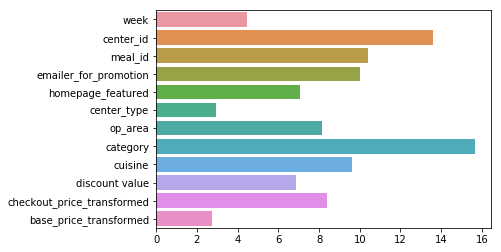

In [126]:
features=model.feature_names_
sns.barplot(model.feature_importances_, features)
plt.show()

In [110]:
test_data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine,discount value,discount percent,discount(yes/no),checkout_price_transformed,base_price_transformed
0,1028232,146,55,1885,158.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,-1.0,-0.628496,1,5.063291,5.069596
1,1262649,147,55,1885,159.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,0.0,0.000000,0,5.069596,5.069596
2,1453211,149,55,1885,157.14,158.14,0,0,647,56,TYPE_C,2.0,Beverages,Thai,-1.0,-0.632351,1,5.057137,5.063481
3,1262599,150,55,1885,159.14,157.14,0,0,647,56,TYPE_C,2.0,Beverages,Thai,2.0,1.272750,0,5.069784,5.057137
4,1495848,151,55,1885,160.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,1.0,0.628496,0,5.075861,5.069596


In [130]:
test=test_data.drop(['id', 'city_code', 'region_code','discount percent','checkout_price', 'base_price','discount(yes/no)'],axis=1)

In [131]:
test["num_orders"]=model.predict(test)

In [133]:
test.to_csv("Submission3.csv")

# New Approach

# Feature engineering - Sine and Cosine transform for ‘week’ - Capture cyclic dependency

In [86]:
train_data['week_sin'] = np.sin(2 * np.pi * train_data['week'] / 52.143)
train_data['week_cos'] = np.cos(2 * np.pi * train_data['week'] / 52.143)

test_data['week_sin'] = np.sin(2 * np.pi * test_data['week'] / 52.143)
test_data['week_cos'] = np.cos(2 * np.pi * test_data['week'] / 52.143)

# Feature engineering - Convert ‘city_code’ and ‘region_code’ into a single feature - ‘city_region’

In [87]:
train_data['city_region'] = train_data['city_code'].astype('str') + '_' + train_data['region_code'].astype('str')

test_data['city_region'] = test_data['city_code'].astype('str') + '_' + test_data['region_code'].astype('str')

# Feature engineering - Convert the ad campaign features - ‘emailer_for_promotion’ and ‘homepage_featured’ into a single feature

In [88]:
train_data['email_plus_homepage'] = train_data['emailer_for_promotion'] + train_data['homepage_featured']

test_data['email_plus_homepage'] = test_data['emailer_for_promotion'] + test_data['homepage_featured']

# Log transform the target variable - num_orders

In [89]:
train_data['num_orders_log1p'] = np.log1p(train_data['num_orders'])

# Train + validation split - Last 10 weeks taken for validations, as the unseen data is for 10 weeks

In [90]:
train_data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,discount percent,discount(yes/no),num_orders_transformed,checkout_price_transformed,base_price_transformed,week_sin,week_cos,city_region,email_plus_homepage,num_orders_log1p
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,...,-10.151684,1,5.176150,4.918739,5.025787,0.120208,0.992749,647_56,0,5.181784
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,...,-10.808326,1,5.777652,4.911404,5.025787,0.238672,0.971100,647_56,0,5.780744
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,...,-0.746714,1,4.564348,4.889747,4.897243,0.353675,0.935368,647_56,0,4.574711
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,...,0.741510,0,5.093750,4.911625,4.904237,0.463549,0.886071,647_56,0,5.099866
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,...,-0.677966,1,5.370638,4.987025,4.993828,0.566700,0.823924,647_56,0,5.375278


In [91]:
train_data.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'discount value', 'discount percent', 'discount(yes/no)',
       'num_orders_transformed', 'checkout_price_transformed',
       'base_price_transformed', 'week_sin', 'week_cos', 'city_region',
       'email_plus_homepage', 'num_orders_log1p'],
      dtype='object')

In [92]:
test_data.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'discount value', 'discount percent', 'discount(yes/no)',
       'checkout_price_transformed', 'base_price_transformed', 'week_sin',
       'week_cos', 'city_region', 'email_plus_homepage'],
      dtype='object')

In [93]:
#Train-vaidation Split
trn=train_data[train_data["week"]<136]
val=train_data[train_data["week"]>135]

In [94]:
x_train=trn.drop(['id','num_orders_log1p', 'num_orders','emailer_for_promotion', 'homepage_featured', 'city_code', 'region_code','discount percent','discount(yes/no)','num_orders_transformed','checkout_price', 'base_price', 'city_region'],axis=1)
y_train=trn.num_orders_log1p
x_val=val.drop(['id','num_orders_log1p', 'num_orders','emailer_for_promotion', 'homepage_featured', 'city_code', 'region_code','discount percent','discount(yes/no)','num_orders_transformed','checkout_price', 'base_price', 'city_region'],axis=1)
y_val=val.num_orders_log1p
#removed from model -, 'city_region'- doing this once only to test
#changing checkout and base price to log transformed

# Modeling - Catboost_2
No improvement in rank

In [96]:
x_train.dtypes

week                            int64
center_id                       int64
meal_id                         int64
center_type                    object
op_area                       float64
category                       object
cuisine                        object
discount value                float64
checkout_price_transformed    float64
base_price_transformed        float64
week_sin                      float64
week_cos                      float64
email_plus_homepage             int64
dtype: object

In [97]:
categorical_features_indices = [1, 2, 3, 5, 6, 12]

In [98]:
model1=CatBoostRegressor(iterations=500, depth=10, learning_rate=0.1,loss_function='RMSE')
model1.fit(x_train, y_train,cat_features=categorical_features_indices,eval_set=(x_val, y_val),plot=True,verbose=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4.5506333	test: 4.4815321	best: 4.4815321 (0)	total: 2.55s	remaining: 21m 14s
1:	learn: 4.1081110	test: 4.0446925	best: 4.0446925 (1)	total: 3.78s	remaining: 15m 41s
2:	learn: 3.7187317	test: 3.6587611	best: 3.6587611 (2)	total: 4.15s	remaining: 11m 27s
3:	learn: 3.3617701	test: 3.3086755	best: 3.3086755 (3)	total: 5.58s	remaining: 11m 32s
4:	learn: 3.0426503	test: 2.9939039	best: 2.9939039 (4)	total: 6.93s	remaining: 11m 26s
5:	learn: 2.7560413	test: 2.7124799	best: 2.7124799 (5)	total: 7.95s	remaining: 10m 54s
6:	learn: 2.4998630	test: 2.4611113	best: 2.4611113 (6)	total: 9.4s	remaining: 11m 2s
7:	learn: 2.2712265	test: 2.2353817	best: 2.2353817 (7)	total: 10.8s	remaining: 11m 3s
8:	learn: 2.0676203	test: 2.0355678	best: 2.0355678 (8)	total: 12s	remaining: 10m 56s
9:	learn: 1.8857936	test: 1.8616039	best: 1.8616039 (9)	total: 13.4s	remaining: 10m 56s
10:	learn: 1.7246764	test: 1.7030315	best: 1.7030315 (10)	total: 14.7s	remaining: 10m 54s
11:	learn: 1.5810382	test: 1.563017

92:	learn: 0.5090028	test: 0.5314578	best: 0.5314578 (92)	total: 2m 6s	remaining: 9m 12s
93:	learn: 0.5083712	test: 0.5312435	best: 0.5312435 (93)	total: 2m 7s	remaining: 9m 11s
94:	learn: 0.5077286	test: 0.5308184	best: 0.5308184 (94)	total: 2m 9s	remaining: 9m 10s
95:	learn: 0.5073338	test: 0.5292368	best: 0.5292368 (95)	total: 2m 10s	remaining: 9m 10s
96:	learn: 0.5069386	test: 0.5289451	best: 0.5289451 (96)	total: 2m 12s	remaining: 9m 8s
97:	learn: 0.5065977	test: 0.5287119	best: 0.5287119 (97)	total: 2m 13s	remaining: 9m 8s
98:	learn: 0.5061867	test: 0.5282619	best: 0.5282619 (98)	total: 2m 15s	remaining: 9m 7s
99:	learn: 0.5055308	test: 0.5279842	best: 0.5279842 (99)	total: 2m 16s	remaining: 9m 7s
100:	learn: 0.5049718	test: 0.5278935	best: 0.5278935 (100)	total: 2m 18s	remaining: 9m 5s
101:	learn: 0.5044077	test: 0.5276354	best: 0.5276354 (101)	total: 2m 19s	remaining: 9m 5s
102:	learn: 0.5040262	test: 0.5272130	best: 0.5272130 (102)	total: 2m 20s	remaining: 9m 3s
103:	learn: 0.

182:	learn: 0.4792903	test: 0.5160862	best: 0.5150244 (178)	total: 4m 20s	remaining: 7m 31s
183:	learn: 0.4791055	test: 0.5162270	best: 0.5150244 (178)	total: 4m 22s	remaining: 7m 30s
184:	learn: 0.4789504	test: 0.5160525	best: 0.5150244 (178)	total: 4m 23s	remaining: 7m 29s
185:	learn: 0.4788225	test: 0.5160476	best: 0.5150244 (178)	total: 4m 24s	remaining: 7m 27s
186:	learn: 0.4786071	test: 0.5159986	best: 0.5150244 (178)	total: 4m 26s	remaining: 7m 25s
187:	learn: 0.4782698	test: 0.5157091	best: 0.5150244 (178)	total: 4m 28s	remaining: 7m 25s
188:	learn: 0.4781384	test: 0.5156978	best: 0.5150244 (178)	total: 4m 29s	remaining: 7m 23s
189:	learn: 0.4780273	test: 0.5156813	best: 0.5150244 (178)	total: 4m 31s	remaining: 7m 22s
190:	learn: 0.4778334	test: 0.5161279	best: 0.5150244 (178)	total: 4m 32s	remaining: 7m 20s
191:	learn: 0.4775442	test: 0.5160554	best: 0.5150244 (178)	total: 4m 33s	remaining: 7m 19s
192:	learn: 0.4774458	test: 0.5163121	best: 0.5150244 (178)	total: 4m 35s	remain

272:	learn: 0.4641911	test: 0.5108961	best: 0.5108961 (272)	total: 6m 34s	remaining: 5m 28s
273:	learn: 0.4640622	test: 0.5108315	best: 0.5108315 (273)	total: 6m 36s	remaining: 5m 27s
274:	learn: 0.4638098	test: 0.5106024	best: 0.5106024 (274)	total: 6m 38s	remaining: 5m 25s
275:	learn: 0.4636600	test: 0.5105412	best: 0.5105412 (275)	total: 6m 39s	remaining: 5m 24s
276:	learn: 0.4635016	test: 0.5106352	best: 0.5105412 (275)	total: 6m 41s	remaining: 5m 22s
277:	learn: 0.4633906	test: 0.5112576	best: 0.5105412 (275)	total: 6m 42s	remaining: 5m 21s
278:	learn: 0.4632405	test: 0.5112021	best: 0.5105412 (275)	total: 6m 44s	remaining: 5m 20s
279:	learn: 0.4631076	test: 0.5110407	best: 0.5105412 (275)	total: 6m 46s	remaining: 5m 19s
280:	learn: 0.4629782	test: 0.5109843	best: 0.5105412 (275)	total: 6m 47s	remaining: 5m 17s
281:	learn: 0.4627735	test: 0.5108432	best: 0.5105412 (275)	total: 6m 49s	remaining: 5m 16s
282:	learn: 0.4626631	test: 0.5107948	best: 0.5105412 (275)	total: 6m 51s	remain

362:	learn: 0.4540504	test: 0.5133530	best: 0.5105412 (275)	total: 8m 53s	remaining: 3m 21s
363:	learn: 0.4539074	test: 0.5133080	best: 0.5105412 (275)	total: 8m 55s	remaining: 3m 19s
364:	learn: 0.4538312	test: 0.5136444	best: 0.5105412 (275)	total: 8m 57s	remaining: 3m 18s
365:	learn: 0.4537403	test: 0.5134150	best: 0.5105412 (275)	total: 8m 58s	remaining: 3m 17s
366:	learn: 0.4536898	test: 0.5133245	best: 0.5105412 (275)	total: 9m	remaining: 3m 15s
367:	learn: 0.4536103	test: 0.5132607	best: 0.5105412 (275)	total: 9m 2s	remaining: 3m 14s
368:	learn: 0.4534871	test: 0.5132540	best: 0.5105412 (275)	total: 9m 4s	remaining: 3m 13s
369:	learn: 0.4533844	test: 0.5132061	best: 0.5105412 (275)	total: 9m 6s	remaining: 3m 11s
370:	learn: 0.4532770	test: 0.5132399	best: 0.5105412 (275)	total: 9m 7s	remaining: 3m 10s
371:	learn: 0.4532151	test: 0.5130246	best: 0.5105412 (275)	total: 9m 9s	remaining: 3m 9s
372:	learn: 0.4531254	test: 0.5130435	best: 0.5105412 (275)	total: 9m 11s	remaining: 3m 7s

452:	learn: 0.4464313	test: 0.5138333	best: 0.5105412 (275)	total: 11m 12s	remaining: 1m 9s
453:	learn: 0.4463862	test: 0.5138456	best: 0.5105412 (275)	total: 11m 13s	remaining: 1m 8s
454:	learn: 0.4463096	test: 0.5138440	best: 0.5105412 (275)	total: 11m 15s	remaining: 1m 6s
455:	learn: 0.4462251	test: 0.5137386	best: 0.5105412 (275)	total: 11m 16s	remaining: 1m 5s
456:	learn: 0.4461327	test: 0.5139141	best: 0.5105412 (275)	total: 11m 17s	remaining: 1m 3s
457:	learn: 0.4459909	test: 0.5141016	best: 0.5105412 (275)	total: 11m 19s	remaining: 1m 2s
458:	learn: 0.4458714	test: 0.5141428	best: 0.5105412 (275)	total: 11m 20s	remaining: 1m
459:	learn: 0.4458055	test: 0.5140556	best: 0.5105412 (275)	total: 11m 21s	remaining: 59.3s
460:	learn: 0.4457332	test: 0.5140464	best: 0.5105412 (275)	total: 11m 23s	remaining: 57.8s
461:	learn: 0.4456706	test: 0.5140472	best: 0.5105412 (275)	total: 11m 24s	remaining: 56.3s
462:	learn: 0.4455910	test: 0.5140357	best: 0.5105412 (275)	total: 11m 26s	remainin

In [99]:
#Training Set
100 * np.sqrt(mean_squared_log_error(np.clip(np.expm1(model1.predict(x_train)), 0, 10000), np.expm1(y_train)))

46.41619480192833

In [100]:
#Validation Set
100 * np.sqrt(mean_squared_log_error(np.clip(np.expm1(model1.predict(x_val)), 0, 10000), np.expm1(y_val)))

51.544063161043866

In [101]:
print("params : ", model1.get_params())
print("Learning rate: ", model1.learning_rate_)
print("tree counts: ", model1.tree_count_)

params :  {'iterations': 500, 'learning_rate': 0.1, 'depth': 10, 'loss_function': 'RMSE'}
Learning rate:  0.1000000015
tree counts:  276


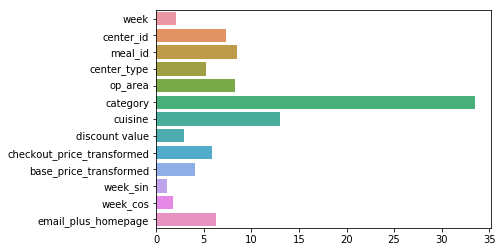

In [102]:
features=model1.feature_names_
sns.barplot(model1.feature_importances_, features)
plt.show()

In [103]:
test=test_data.drop(['id','emailer_for_promotion', 'homepage_featured', 'city_code', 'region_code','discount percent','discount(yes/no)','checkout_price', 'base_price', 'city_region'],axis=1)
#removed from model -, 'city_region'- doing this once only to test
#changing checkout and base price to log transformed

In [104]:
test.dtypes

week                            int64
center_id                       int64
meal_id                         int64
center_type                    object
op_area                       float64
category                       object
cuisine                        object
discount value                float64
checkout_price_transformed    float64
base_price_transformed        float64
week_sin                      float64
week_cos                      float64
email_plus_homepage             int64
dtype: object

In [230]:
test["num_orders_log1p"]=model1.predict(test)

In [231]:
test["num_orders"] = np.expm1(test["num_orders_log1p"])

In [232]:
test.to_csv("Submission2_new.csv")

# Modeling - LightGBM_1

No change in ranking

In [95]:
# Label encode categorical columns for use in LightGBM.
label_encode_columns = ['center_id', 
                        'meal_id',  
                        'city_region', 
                        'center_type', 
                        'category', 
                        'cuisine']
le = preprocessing.LabelEncoder()

for col in label_encode_columns:
    le.fit(train_data[col])
    train_data[col + '_encoded'] = le.transform(train_data[col])
    test_data[col + '_encoded'] = le.transform(test_data[col])

In [96]:
train_data.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'discount value', 'discount percent', 'discount(yes/no)',
       'num_orders_transformed', 'checkout_price_transformed',
       'base_price_transformed', 'week_sin', 'week_cos', 'city_region',
       'email_plus_homepage', 'num_orders_log1p', 'center_id_encoded',
       'meal_id_encoded', 'city_region_encoded', 'center_type_encoded',
       'category_encoded', 'cuisine_encoded'],
      dtype='object')

In [143]:
# Prepare a list of columns to train on.
# Also decide which features to treat as numeric and which features to treat
# as categorical.
columns_to_train = ['week', 
                    'checkout_price', 
                    'base_price', 
                    'op_area', 
                    'discount value',
                    'week_sin', 
                    'week_cos', 
                    'email_plus_homepage', 
                    'center_id_encoded',
                    'meal_id_encoded', 
                    'city_region_encoded', 
                    'center_type_encoded',
                    'category_encoded', 
                    'cuisine_encoded']

categorical_columns = ['category_encoded', 
                       'center_id_encoded', 
                       'center_type_encoded', 
                       'city_region_encoded', 
                       'cuisine_encoded', 
                       'email_plus_homepage', 
                       'meal_id_encoded']

numerical_columns = [col for col in columns_to_train if col not in categorical_columns]


In [144]:
#Train-vaidation Split
trn=train_data[train_data["week"]<136]
val=train_data[train_data["week"]>135]

In [145]:
x_train=trn.drop(['id','num_orders_log1p', 'center_id', 'meal_id','center_type', 'category', 'cuisine', 'num_orders','emailer_for_promotion', 'homepage_featured', 'city_code', 'region_code','city_region','discount percent','discount(yes/no)','num_orders_transformed','checkout_price_transformed', 'base_price_transformed'],axis=1)
y_train=trn.num_orders_log1p
x_val=val.drop(['id','num_orders_log1p', 'center_id', 'meal_id','center_type', 'category', 'cuisine', 'num_orders','emailer_for_promotion', 'homepage_featured', 'city_code', 'region_code','city_region','discount percent','discount(yes/no)','num_orders_transformed','checkout_price_transformed', 'base_price_transformed'],axis=1)
y_val=val.num_orders_log1p

In [146]:
x_train.columns

Index(['week', 'checkout_price', 'base_price', 'op_area', 'discount value',
       'week_sin', 'week_cos', 'email_plus_homepage', 'center_id_encoded',
       'meal_id_encoded', 'city_region_encoded', 'center_type_encoded',
       'category_encoded', 'cuisine_encoded'],
      dtype='object')

In [147]:
# Train the LightGBM model on the best parameters obtained by grid search.
g = {'colsample_bytree': 0.4,
     'min_child_samples': 5,
     'num_leaves': 255}

estimator = LGBMRegressor(learning_rate=0.05,
                          n_estimators=20000,
                          silent=False,
                          **g)

fit_params = {'early_stopping_rounds': 1000,
              'feature_name': categorical_columns + numerical_columns,
              'categorical_feature': categorical_columns,
              'eval_set': [(x_train, y_train), (x_val, y_val)]}

estimator.fit(x_train, y_train, **fit_params)

C:\Users\abhay\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['category_encoded', 'center_id_encoded', 'center_type_encoded', 'city_region_encoded', 'cuisine_encoded', 'email_plus_homepage', 'meal_id_encoded']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\abhay\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['category_encoded', 'center_id_encoded', 'center_type_encoded', 'city_region_encoded', 'cuisine_encoded', 'email_plus_homepage', 'meal_id_encoded']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 1.43445	valid_1's l2: 1.3069
Training until validation scores don't improve for 1000 rounds.
[2]	training's l2: 1.3433	valid_1's l2: 1.2339
[3]	training's l2: 1.28535	valid_1's l2: 1.19879
[4]	training's l2: 1.21081	valid_1's l2: 1.14285
[5]	training's l2: 1.20271	valid_1's l2: 1.13423
[6]	training's l2: 1.14644	valid_1's l2: 1.082
[7]	training's l2: 1.07894	valid_1's l2: 1.02166
[8]	training's l2: 1.01821	valid_1's l2: 0.967985
[9]	training's l2: 0.962016	valid_1's l2: 0.91877
[10]	training's l2: 0.91491	valid_1's l2: 0.878822
[11]	training's l2: 0.866447	valid_1's l2: 0.832645
[12]	training's l2: 0.833825	valid_1's l2: 0.810421
[13]	training's l2: 0.80405	valid_1's l2: 0.791874
[14]	training's l2: 0.767719	valid_1's l2: 0.761175
[15]	training's l2: 0.735581	valid_1's l2: 0.733266
[16]	training's l2: 0.707492	valid_1's l2: 0.708856
[17]	training's l2: 0.681545	valid_1's l2: 0.683596
[18]	training's l2: 0.65787	valid_1's l2: 0.662492
[19]	training's l2: 0.633893	vali

[316]	training's l2: 0.190534	valid_1's l2: 0.286072
[317]	training's l2: 0.190341	valid_1's l2: 0.285867
[318]	training's l2: 0.190155	valid_1's l2: 0.285863
[319]	training's l2: 0.190143	valid_1's l2: 0.285857
[320]	training's l2: 0.190008	valid_1's l2: 0.285643
[321]	training's l2: 0.189976	valid_1's l2: 0.285622
[322]	training's l2: 0.189956	valid_1's l2: 0.285573
[323]	training's l2: 0.189926	valid_1's l2: 0.285528
[324]	training's l2: 0.189862	valid_1's l2: 0.285462
[325]	training's l2: 0.189794	valid_1's l2: 0.285449
[326]	training's l2: 0.18975	valid_1's l2: 0.285434
[327]	training's l2: 0.189629	valid_1's l2: 0.285503
[328]	training's l2: 0.189556	valid_1's l2: 0.285449
[329]	training's l2: 0.189527	valid_1's l2: 0.28543
[330]	training's l2: 0.189429	valid_1's l2: 0.285477
[331]	training's l2: 0.189232	valid_1's l2: 0.285519
[332]	training's l2: 0.189036	valid_1's l2: 0.285563
[333]	training's l2: 0.188976	valid_1's l2: 0.285518
[334]	training's l2: 0.18886	valid_1's l2: 0.285

[471]	training's l2: 0.177759	valid_1's l2: 0.282289
[472]	training's l2: 0.177738	valid_1's l2: 0.282271
[473]	training's l2: 0.177705	valid_1's l2: 0.282267
[474]	training's l2: 0.177673	valid_1's l2: 0.282265
[475]	training's l2: 0.177566	valid_1's l2: 0.282338
[476]	training's l2: 0.177508	valid_1's l2: 0.282243
[477]	training's l2: 0.177402	valid_1's l2: 0.282291
[478]	training's l2: 0.177375	valid_1's l2: 0.282282
[479]	training's l2: 0.177261	valid_1's l2: 0.282289
[480]	training's l2: 0.177235	valid_1's l2: 0.282295
[481]	training's l2: 0.177199	valid_1's l2: 0.28225
[482]	training's l2: 0.17713	valid_1's l2: 0.282196
[483]	training's l2: 0.177121	valid_1's l2: 0.282172
[484]	training's l2: 0.177067	valid_1's l2: 0.282139
[485]	training's l2: 0.177034	valid_1's l2: 0.282091
[486]	training's l2: 0.177004	valid_1's l2: 0.282042
[487]	training's l2: 0.176938	valid_1's l2: 0.282052
[488]	training's l2: 0.176826	valid_1's l2: 0.28218
[489]	training's l2: 0.176823	valid_1's l2: 0.282

[629]	training's l2: 0.169688	valid_1's l2: 0.281692
[630]	training's l2: 0.169662	valid_1's l2: 0.281732
[631]	training's l2: 0.169591	valid_1's l2: 0.281662
[632]	training's l2: 0.169555	valid_1's l2: 0.281673
[633]	training's l2: 0.16952	valid_1's l2: 0.281652
[634]	training's l2: 0.169413	valid_1's l2: 0.281606
[635]	training's l2: 0.169375	valid_1's l2: 0.281596
[636]	training's l2: 0.169293	valid_1's l2: 0.281626
[637]	training's l2: 0.169212	valid_1's l2: 0.28152
[638]	training's l2: 0.169204	valid_1's l2: 0.281516
[639]	training's l2: 0.169196	valid_1's l2: 0.28151
[640]	training's l2: 0.169161	valid_1's l2: 0.281496
[641]	training's l2: 0.169054	valid_1's l2: 0.281479
[642]	training's l2: 0.169033	valid_1's l2: 0.281484
[643]	training's l2: 0.169003	valid_1's l2: 0.281461
[644]	training's l2: 0.168978	valid_1's l2: 0.281444
[645]	training's l2: 0.168958	valid_1's l2: 0.281438
[646]	training's l2: 0.168923	valid_1's l2: 0.281435
[647]	training's l2: 0.168888	valid_1's l2: 0.281

[786]	training's l2: 0.163837	valid_1's l2: 0.280869
[787]	training's l2: 0.163821	valid_1's l2: 0.280875
[788]	training's l2: 0.16375	valid_1's l2: 0.280793
[789]	training's l2: 0.163733	valid_1's l2: 0.280764
[790]	training's l2: 0.163718	valid_1's l2: 0.280769
[791]	training's l2: 0.163714	valid_1's l2: 0.280768
[792]	training's l2: 0.163687	valid_1's l2: 0.280771
[793]	training's l2: 0.163664	valid_1's l2: 0.28078
[794]	training's l2: 0.163573	valid_1's l2: 0.280847
[795]	training's l2: 0.163539	valid_1's l2: 0.280857
[796]	training's l2: 0.163477	valid_1's l2: 0.280827
[797]	training's l2: 0.163442	valid_1's l2: 0.28081
[798]	training's l2: 0.163418	valid_1's l2: 0.280804
[799]	training's l2: 0.163404	valid_1's l2: 0.280783
[800]	training's l2: 0.163386	valid_1's l2: 0.280779
[801]	training's l2: 0.163321	valid_1's l2: 0.280708
[802]	training's l2: 0.163307	valid_1's l2: 0.2807
[803]	training's l2: 0.163286	valid_1's l2: 0.280662
[804]	training's l2: 0.163271	valid_1's l2: 0.28066

[946]	training's l2: 0.158708	valid_1's l2: 0.280555
[947]	training's l2: 0.158705	valid_1's l2: 0.280551
[948]	training's l2: 0.158661	valid_1's l2: 0.280563
[949]	training's l2: 0.158644	valid_1's l2: 0.280563
[950]	training's l2: 0.158586	valid_1's l2: 0.280584
[951]	training's l2: 0.158567	valid_1's l2: 0.28058
[952]	training's l2: 0.158536	valid_1's l2: 0.280524
[953]	training's l2: 0.15847	valid_1's l2: 0.280547
[954]	training's l2: 0.158416	valid_1's l2: 0.280574
[955]	training's l2: 0.158412	valid_1's l2: 0.280577
[956]	training's l2: 0.158376	valid_1's l2: 0.280622
[957]	training's l2: 0.158371	valid_1's l2: 0.280619
[958]	training's l2: 0.158352	valid_1's l2: 0.280615
[959]	training's l2: 0.158341	valid_1's l2: 0.280615
[960]	training's l2: 0.158326	valid_1's l2: 0.280607
[961]	training's l2: 0.158299	valid_1's l2: 0.280614
[962]	training's l2: 0.158272	valid_1's l2: 0.280606
[963]	training's l2: 0.158175	valid_1's l2: 0.280706
[964]	training's l2: 0.158157	valid_1's l2: 0.28

[1100]	training's l2: 0.154602	valid_1's l2: 0.280875
[1101]	training's l2: 0.154581	valid_1's l2: 0.280878
[1102]	training's l2: 0.154576	valid_1's l2: 0.280874
[1103]	training's l2: 0.154563	valid_1's l2: 0.280854
[1104]	training's l2: 0.15448	valid_1's l2: 0.280856
[1105]	training's l2: 0.154459	valid_1's l2: 0.280853
[1106]	training's l2: 0.154445	valid_1's l2: 0.280851
[1107]	training's l2: 0.154444	valid_1's l2: 0.280849
[1108]	training's l2: 0.154404	valid_1's l2: 0.280943
[1109]	training's l2: 0.154399	valid_1's l2: 0.280939
[1110]	training's l2: 0.154387	valid_1's l2: 0.280938
[1111]	training's l2: 0.154377	valid_1's l2: 0.280936
[1112]	training's l2: 0.154353	valid_1's l2: 0.280908
[1113]	training's l2: 0.154335	valid_1's l2: 0.280911
[1114]	training's l2: 0.154311	valid_1's l2: 0.280902
[1115]	training's l2: 0.154293	valid_1's l2: 0.280903
[1116]	training's l2: 0.154278	valid_1's l2: 0.280907
[1117]	training's l2: 0.154256	valid_1's l2: 0.280912
[1118]	training's l2: 0.15425

[1255]	training's l2: 0.150773	valid_1's l2: 0.281385
[1256]	training's l2: 0.150717	valid_1's l2: 0.281325
[1257]	training's l2: 0.150716	valid_1's l2: 0.281325
[1258]	training's l2: 0.150705	valid_1's l2: 0.281318
[1259]	training's l2: 0.15064	valid_1's l2: 0.28133
[1260]	training's l2: 0.150589	valid_1's l2: 0.281378
[1261]	training's l2: 0.150534	valid_1's l2: 0.281321
[1262]	training's l2: 0.150527	valid_1's l2: 0.281313
[1263]	training's l2: 0.150519	valid_1's l2: 0.281294
[1264]	training's l2: 0.150511	valid_1's l2: 0.281294
[1265]	training's l2: 0.150487	valid_1's l2: 0.281302
[1266]	training's l2: 0.150456	valid_1's l2: 0.281302
[1267]	training's l2: 0.150429	valid_1's l2: 0.281302
[1268]	training's l2: 0.150405	valid_1's l2: 0.281313
[1269]	training's l2: 0.15037	valid_1's l2: 0.281313
[1270]	training's l2: 0.150356	valid_1's l2: 0.281332
[1271]	training's l2: 0.150347	valid_1's l2: 0.281316
[1272]	training's l2: 0.150335	valid_1's l2: 0.281317
[1273]	training's l2: 0.150334	

[1412]	training's l2: 0.147346	valid_1's l2: 0.281293
[1413]	training's l2: 0.147342	valid_1's l2: 0.281297
[1414]	training's l2: 0.147325	valid_1's l2: 0.281295
[1415]	training's l2: 0.147292	valid_1's l2: 0.281314
[1416]	training's l2: 0.14722	valid_1's l2: 0.281299
[1417]	training's l2: 0.14721	valid_1's l2: 0.281301
[1418]	training's l2: 0.147209	valid_1's l2: 0.2813
[1419]	training's l2: 0.147182	valid_1's l2: 0.2813
[1420]	training's l2: 0.147161	valid_1's l2: 0.281316
[1421]	training's l2: 0.147122	valid_1's l2: 0.281272
[1422]	training's l2: 0.147118	valid_1's l2: 0.281272
[1423]	training's l2: 0.147099	valid_1's l2: 0.281253
[1424]	training's l2: 0.147086	valid_1's l2: 0.281252
[1425]	training's l2: 0.147072	valid_1's l2: 0.281233
[1426]	training's l2: 0.147067	valid_1's l2: 0.281227
[1427]	training's l2: 0.147049	valid_1's l2: 0.281215
[1428]	training's l2: 0.147043	valid_1's l2: 0.281213
[1429]	training's l2: 0.147019	valid_1's l2: 0.281203
[1430]	training's l2: 0.147011	val

[1566]	training's l2: 0.144612	valid_1's l2: 0.281584
[1567]	training's l2: 0.14461	valid_1's l2: 0.281584
[1568]	training's l2: 0.14458	valid_1's l2: 0.281571
[1569]	training's l2: 0.14457	valid_1's l2: 0.281568
[1570]	training's l2: 0.14457	valid_1's l2: 0.281567
[1571]	training's l2: 0.144559	valid_1's l2: 0.281562
[1572]	training's l2: 0.14451	valid_1's l2: 0.281554
[1573]	training's l2: 0.144469	valid_1's l2: 0.28161
[1574]	training's l2: 0.144459	valid_1's l2: 0.281602
[1575]	training's l2: 0.144446	valid_1's l2: 0.2816
[1576]	training's l2: 0.14442	valid_1's l2: 0.281629
[1577]	training's l2: 0.144401	valid_1's l2: 0.281646
[1578]	training's l2: 0.144383	valid_1's l2: 0.281643
[1579]	training's l2: 0.144355	valid_1's l2: 0.281643
[1580]	training's l2: 0.144353	valid_1's l2: 0.281643
[1581]	training's l2: 0.144307	valid_1's l2: 0.281628
[1582]	training's l2: 0.144286	valid_1's l2: 0.28162
[1583]	training's l2: 0.144275	valid_1's l2: 0.281622
[1584]	training's l2: 0.144272	valid_1

[1720]	training's l2: 0.141997	valid_1's l2: 0.281466
[1721]	training's l2: 0.141996	valid_1's l2: 0.281464
[1722]	training's l2: 0.141981	valid_1's l2: 0.281458
[1723]	training's l2: 0.141965	valid_1's l2: 0.28149
[1724]	training's l2: 0.141963	valid_1's l2: 0.281493
[1725]	training's l2: 0.141952	valid_1's l2: 0.281491
[1726]	training's l2: 0.141951	valid_1's l2: 0.28149
[1727]	training's l2: 0.14195	valid_1's l2: 0.281487
[1728]	training's l2: 0.141939	valid_1's l2: 0.28149
[1729]	training's l2: 0.141924	valid_1's l2: 0.281458
[1730]	training's l2: 0.141923	valid_1's l2: 0.281458
[1731]	training's l2: 0.141921	valid_1's l2: 0.28146
[1732]	training's l2: 0.141907	valid_1's l2: 0.281466
[1733]	training's l2: 0.141894	valid_1's l2: 0.281461
[1734]	training's l2: 0.141865	valid_1's l2: 0.281451
[1735]	training's l2: 0.141828	valid_1's l2: 0.28154
[1736]	training's l2: 0.141789	valid_1's l2: 0.28148
[1737]	training's l2: 0.14177	valid_1's l2: 0.281461
[1738]	training's l2: 0.141767	valid

[1875]	training's l2: 0.139381	valid_1's l2: 0.282083
[1876]	training's l2: 0.139368	valid_1's l2: 0.282076
[1877]	training's l2: 0.139356	valid_1's l2: 0.282098
[1878]	training's l2: 0.139347	valid_1's l2: 0.282102
[1879]	training's l2: 0.139315	valid_1's l2: 0.282091
[1880]	training's l2: 0.139314	valid_1's l2: 0.282091
[1881]	training's l2: 0.139304	valid_1's l2: 0.282099
[1882]	training's l2: 0.139252	valid_1's l2: 0.282098
[1883]	training's l2: 0.139249	valid_1's l2: 0.282099
[1884]	training's l2: 0.139237	valid_1's l2: 0.2821
[1885]	training's l2: 0.139228	valid_1's l2: 0.282103
[1886]	training's l2: 0.139214	valid_1's l2: 0.282084
[1887]	training's l2: 0.139197	valid_1's l2: 0.282177
[1888]	training's l2: 0.139178	valid_1's l2: 0.282202
[1889]	training's l2: 0.139151	valid_1's l2: 0.28238
[1890]	training's l2: 0.139141	valid_1's l2: 0.282387
[1891]	training's l2: 0.139134	valid_1's l2: 0.2824
[1892]	training's l2: 0.139107	valid_1's l2: 0.282397
[1893]	training's l2: 0.139106	va

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=20000, n_jobs=-1, num_leaves=255, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [148]:
pred_x_train=estimator.predict(x_train)

In [149]:
pred_x_val=estimator.predict(x_val)

In [150]:
#Training Set
100 * np.sqrt(mean_squared_log_error(np.expm1(pred_x_train), np.expm1(y_train)))

39.558606976981

In [151]:
#Validation Set
100 * np.sqrt(mean_squared_log_error(np.expm1(pred_x_val), np.expm1(y_val)))

52.23042637263401

In [106]:
test=test_data.drop(['id', 'center_id', 'meal_id','center_type', 'category', 'cuisine','emailer_for_promotion', 'homepage_featured', 'city_code', 'region_code','city_region','discount percent','discount(yes/no)','checkout_price_transformed', 'base_price_transformed'],axis=1)

In [107]:
test["num_orders_log1p"] = estimator.predict(test)
test["num_orders"] = np.expm1(test["num_orders_log1p"])

In [108]:
test.to_csv("Submission2.csv")

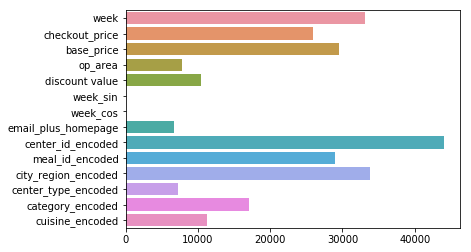

In [154]:
#feature importance curve
sns.barplot(estimator.feature_importances_, x_train.columns)
plt.show()

# Modeling - LightGBM_2

In [155]:
# Prepare a list of columns to train on.
# Also decide which features to treat as numeric and which features to treat
# as categorical.
columns_to_train = ['week', 'op_area', 'discount value', 'week_sin', 'week_cos',
       'email_plus_homepage', 'center_id_encoded', 'meal_id_encoded',
       'center_type_encoded', 'category_encoded',
       'cuisine_encoded']

categorical_columns = ['category_encoded', 
                       'center_id_encoded', 
                       'center_type_encoded', 
                       'cuisine_encoded', 
                       'email_plus_homepage', 
                       'meal_id_encoded']

numerical_columns = [col for col in columns_to_train if col not in categorical_columns]


In [156]:
#Train-vaidation Split
trn=train_data[train_data["week"]<136]
val=train_data[train_data["week"]>135]

In [157]:
x_train=trn.drop(['id','num_orders_log1p','checkout_price', 'base_price','city_region_encoded', 'center_id', 'meal_id','center_type', 'category', 'cuisine', 'num_orders','emailer_for_promotion', 'homepage_featured', 'city_code', 'region_code','city_region','discount percent','discount(yes/no)','num_orders_transformed','checkout_price_transformed', 'base_price_transformed'],axis=1)
y_train=trn.num_orders_log1p
x_val=val.drop(['id','num_orders_log1p','checkout_price', 'base_price','city_region_encoded',  'center_id', 'meal_id','center_type', 'category', 'cuisine', 'num_orders','emailer_for_promotion', 'homepage_featured', 'city_code', 'region_code','city_region','discount percent','discount(yes/no)','num_orders_transformed','checkout_price_transformed', 'base_price_transformed'],axis=1)
y_val=val.num_orders_log1p

In [158]:
x_train.columns

Index(['week', 'op_area', 'discount value', 'week_sin', 'week_cos',
       'email_plus_homepage', 'center_id_encoded', 'meal_id_encoded',
       'center_type_encoded', 'category_encoded', 'cuisine_encoded'],
      dtype='object')

In [159]:
# Train the LightGBM model on the best parameters obtained by grid search.
g = {'colsample_bytree': 0.6,
     'min_child_samples': 6,
     'num_leaves': 255}

estimator = LGBMRegressor(learning_rate=0.02,
                          n_estimators=15000,
                          silent=False,
                          **g)

fit_params = {'early_stopping_rounds': 5000,
              'feature_name': categorical_columns + numerical_columns,
              'categorical_feature': categorical_columns,
              'eval_set': [(x_train, y_train), (x_val, y_val)]}

estimator.fit(x_train, y_train, **fit_params)

C:\Users\abhay\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['category_encoded', 'center_id_encoded', 'center_type_encoded', 'cuisine_encoded', 'email_plus_homepage', 'meal_id_encoded']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\abhay\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['category_encoded', 'center_id_encoded', 'center_type_encoded', 'cuisine_encoded', 'email_plus_homepage', 'meal_id_encoded']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's l2: 1.41787	valid_1's l2: 1.29152
Training until validation scores don't improve for 5000 rounds.
[2]	training's l2: 1.4021	valid_1's l2: 1.27812
[3]	training's l2: 1.36548	valid_1's l2: 1.24596
[4]	training's l2: 1.35629	valid_1's l2: 1.24129
[5]	training's l2: 1.31903	valid_1's l2: 1.20799
[6]	training's l2: 1.28467	valid_1's l2: 1.17734
[7]	training's l2: 1.25074	valid_1's l2: 1.14788
[8]	training's l2: 1.21761	valid_1's l2: 1.11935
[9]	training's l2: 1.18727	valid_1's l2: 1.09257
[10]	training's l2: 1.15778	valid_1's l2: 1.06641
[11]	training's l2: 1.13002	valid_1's l2: 1.04242
[12]	training's l2: 1.1057	valid_1's l2: 1.02107
[13]	training's l2: 1.08083	valid_1's l2: 1.00057
[14]	training's l2: 1.05431	valid_1's l2: 0.978171
[15]	training's l2: 1.02979	valid_1's l2: 0.955788
[16]	training's l2: 1.02036	valid_1's l2: 0.950019
[17]	training's l2: 1.01626	valid_1's l2: 0.946604
[18]	training's l2: 0.994361	valid_1's l2: 0.926625
[19]	training's l2: 0.975855	valid_1's l2

[158]	training's l2: 0.289812	valid_1's l2: 0.396996
[159]	training's l2: 0.28918	valid_1's l2: 0.396846
[160]	training's l2: 0.28842	valid_1's l2: 0.397375
[161]	training's l2: 0.287943	valid_1's l2: 0.397469
[162]	training's l2: 0.287462	valid_1's l2: 0.397222
[163]	training's l2: 0.287247	valid_1's l2: 0.397201
[164]	training's l2: 0.286718	valid_1's l2: 0.39654
[165]	training's l2: 0.285957	valid_1's l2: 0.395907
[166]	training's l2: 0.285384	valid_1's l2: 0.396337
[167]	training's l2: 0.284814	valid_1's l2: 0.396762
[168]	training's l2: 0.283987	valid_1's l2: 0.396251
[169]	training's l2: 0.283448	valid_1's l2: 0.39654
[170]	training's l2: 0.282883	valid_1's l2: 0.397113
[171]	training's l2: 0.282487	valid_1's l2: 0.397234
[172]	training's l2: 0.281519	valid_1's l2: 0.39669
[173]	training's l2: 0.281121	valid_1's l2: 0.396745
[174]	training's l2: 0.280875	valid_1's l2: 0.396904
[175]	training's l2: 0.280377	valid_1's l2: 0.396651
[176]	training's l2: 0.280207	valid_1's l2: 0.39653

[317]	training's l2: 0.237638	valid_1's l2: 0.390735
[318]	training's l2: 0.237557	valid_1's l2: 0.390717
[319]	training's l2: 0.237341	valid_1's l2: 0.390826
[320]	training's l2: 0.237124	valid_1's l2: 0.390846
[321]	training's l2: 0.236829	valid_1's l2: 0.390638
[322]	training's l2: 0.236687	valid_1's l2: 0.390712
[323]	training's l2: 0.236502	valid_1's l2: 0.390764
[324]	training's l2: 0.236347	valid_1's l2: 0.39059
[325]	training's l2: 0.236076	valid_1's l2: 0.390614
[326]	training's l2: 0.235857	valid_1's l2: 0.390659
[327]	training's l2: 0.235747	valid_1's l2: 0.390825
[328]	training's l2: 0.235519	valid_1's l2: 0.390799
[329]	training's l2: 0.235312	valid_1's l2: 0.390593
[330]	training's l2: 0.235163	valid_1's l2: 0.390792
[331]	training's l2: 0.235059	valid_1's l2: 0.39102
[332]	training's l2: 0.234791	valid_1's l2: 0.390824
[333]	training's l2: 0.234718	valid_1's l2: 0.390807
[334]	training's l2: 0.23453	valid_1's l2: 0.390832
[335]	training's l2: 0.234393	valid_1's l2: 0.390

[474]	training's l2: 0.219971	valid_1's l2: 0.393588
[475]	training's l2: 0.219945	valid_1's l2: 0.393583
[476]	training's l2: 0.219887	valid_1's l2: 0.393596
[477]	training's l2: 0.21983	valid_1's l2: 0.393692
[478]	training's l2: 0.2198	valid_1's l2: 0.393685
[479]	training's l2: 0.219683	valid_1's l2: 0.393596
[480]	training's l2: 0.219618	valid_1's l2: 0.39354
[481]	training's l2: 0.219571	valid_1's l2: 0.393557
[482]	training's l2: 0.219515	valid_1's l2: 0.393881
[483]	training's l2: 0.219436	valid_1's l2: 0.393819
[484]	training's l2: 0.219345	valid_1's l2: 0.393852
[485]	training's l2: 0.219296	valid_1's l2: 0.393841
[486]	training's l2: 0.219239	valid_1's l2: 0.393845
[487]	training's l2: 0.219153	valid_1's l2: 0.393795
[488]	training's l2: 0.219092	valid_1's l2: 0.39374
[489]	training's l2: 0.219046	valid_1's l2: 0.393793
[490]	training's l2: 0.218975	valid_1's l2: 0.393729
[491]	training's l2: 0.218896	valid_1's l2: 0.394048
[492]	training's l2: 0.218855	valid_1's l2: 0.39409

[631]	training's l2: 0.211476	valid_1's l2: 0.396188
[632]	training's l2: 0.21144	valid_1's l2: 0.396217
[633]	training's l2: 0.211411	valid_1's l2: 0.396205
[634]	training's l2: 0.211394	valid_1's l2: 0.396204
[635]	training's l2: 0.211368	valid_1's l2: 0.396263
[636]	training's l2: 0.211351	valid_1's l2: 0.396244
[637]	training's l2: 0.21132	valid_1's l2: 0.396231
[638]	training's l2: 0.211299	valid_1's l2: 0.396233
[639]	training's l2: 0.211255	valid_1's l2: 0.396173
[640]	training's l2: 0.211244	valid_1's l2: 0.396173
[641]	training's l2: 0.211192	valid_1's l2: 0.396322
[642]	training's l2: 0.211159	valid_1's l2: 0.396305
[643]	training's l2: 0.211144	valid_1's l2: 0.396307
[644]	training's l2: 0.21112	valid_1's l2: 0.396309
[645]	training's l2: 0.211091	valid_1's l2: 0.39633
[646]	training's l2: 0.211027	valid_1's l2: 0.396357
[647]	training's l2: 0.210955	valid_1's l2: 0.396288
[648]	training's l2: 0.21093	valid_1's l2: 0.396277
[649]	training's l2: 0.210901	valid_1's l2: 0.39628

[790]	training's l2: 0.205789	valid_1's l2: 0.396645
[791]	training's l2: 0.205763	valid_1's l2: 0.396637
[792]	training's l2: 0.20573	valid_1's l2: 0.396633
[793]	training's l2: 0.205688	valid_1's l2: 0.396747
[794]	training's l2: 0.205666	valid_1's l2: 0.396727
[795]	training's l2: 0.205629	valid_1's l2: 0.396797
[796]	training's l2: 0.205623	valid_1's l2: 0.396799
[797]	training's l2: 0.2056	valid_1's l2: 0.396803
[798]	training's l2: 0.20558	valid_1's l2: 0.396801
[799]	training's l2: 0.20557	valid_1's l2: 0.396796
[800]	training's l2: 0.205563	valid_1's l2: 0.396793
[801]	training's l2: 0.205528	valid_1's l2: 0.396757
[802]	training's l2: 0.205493	valid_1's l2: 0.39674
[803]	training's l2: 0.205481	valid_1's l2: 0.396748
[804]	training's l2: 0.205429	valid_1's l2: 0.396692
[805]	training's l2: 0.205352	valid_1's l2: 0.396619
[806]	training's l2: 0.205331	valid_1's l2: 0.39662
[807]	training's l2: 0.205296	valid_1's l2: 0.39665
[808]	training's l2: 0.205285	valid_1's l2: 0.396658
[

[946]	training's l2: 0.201212	valid_1's l2: 0.397696
[947]	training's l2: 0.201159	valid_1's l2: 0.397665
[948]	training's l2: 0.201144	valid_1's l2: 0.397662
[949]	training's l2: 0.201128	valid_1's l2: 0.397657
[950]	training's l2: 0.201093	valid_1's l2: 0.397657
[951]	training's l2: 0.201057	valid_1's l2: 0.397665
[952]	training's l2: 0.201031	valid_1's l2: 0.397673
[953]	training's l2: 0.200987	valid_1's l2: 0.397655
[954]	training's l2: 0.200959	valid_1's l2: 0.397709
[955]	training's l2: 0.200929	valid_1's l2: 0.397709
[956]	training's l2: 0.200911	valid_1's l2: 0.397731
[957]	training's l2: 0.200907	valid_1's l2: 0.39773
[958]	training's l2: 0.200879	valid_1's l2: 0.39777
[959]	training's l2: 0.200875	valid_1's l2: 0.397771
[960]	training's l2: 0.20086	valid_1's l2: 0.397773
[961]	training's l2: 0.200849	valid_1's l2: 0.39777
[962]	training's l2: 0.200811	valid_1's l2: 0.397751
[963]	training's l2: 0.200797	valid_1's l2: 0.397746
[964]	training's l2: 0.200773	valid_1's l2: 0.3977

[1105]	training's l2: 0.197436	valid_1's l2: 0.398344
[1106]	training's l2: 0.197429	valid_1's l2: 0.398342
[1107]	training's l2: 0.197409	valid_1's l2: 0.398328
[1108]	training's l2: 0.197399	valid_1's l2: 0.398326
[1109]	training's l2: 0.197372	valid_1's l2: 0.398386
[1110]	training's l2: 0.197348	valid_1's l2: 0.398358
[1111]	training's l2: 0.197344	valid_1's l2: 0.398359
[1112]	training's l2: 0.197327	valid_1's l2: 0.398352
[1113]	training's l2: 0.197314	valid_1's l2: 0.398342
[1114]	training's l2: 0.19728	valid_1's l2: 0.398342
[1115]	training's l2: 0.19727	valid_1's l2: 0.398328
[1116]	training's l2: 0.197254	valid_1's l2: 0.398339
[1117]	training's l2: 0.197244	valid_1's l2: 0.398336
[1118]	training's l2: 0.197231	valid_1's l2: 0.39832
[1119]	training's l2: 0.197201	valid_1's l2: 0.39832
[1120]	training's l2: 0.197165	valid_1's l2: 0.398325
[1121]	training's l2: 0.197161	valid_1's l2: 0.398329
[1122]	training's l2: 0.197097	valid_1's l2: 0.398272
[1123]	training's l2: 0.197083	v

[1259]	training's l2: 0.194704	valid_1's l2: 0.400126
[1260]	training's l2: 0.194692	valid_1's l2: 0.400134
[1261]	training's l2: 0.19468	valid_1's l2: 0.400136
[1262]	training's l2: 0.194664	valid_1's l2: 0.400167
[1263]	training's l2: 0.194622	valid_1's l2: 0.400167
[1264]	training's l2: 0.194604	valid_1's l2: 0.400172
[1265]	training's l2: 0.194588	valid_1's l2: 0.400167
[1266]	training's l2: 0.194574	valid_1's l2: 0.400211
[1267]	training's l2: 0.194533	valid_1's l2: 0.400186
[1268]	training's l2: 0.194527	valid_1's l2: 0.40019
[1269]	training's l2: 0.194505	valid_1's l2: 0.400286
[1270]	training's l2: 0.194477	valid_1's l2: 0.400283
[1271]	training's l2: 0.194435	valid_1's l2: 0.40033
[1272]	training's l2: 0.19442	valid_1's l2: 0.400358
[1273]	training's l2: 0.194406	valid_1's l2: 0.400355
[1274]	training's l2: 0.194389	valid_1's l2: 0.400356
[1275]	training's l2: 0.194385	valid_1's l2: 0.400357
[1276]	training's l2: 0.194363	valid_1's l2: 0.400371
[1277]	training's l2: 0.19435	va

[1413]	training's l2: 0.191797	valid_1's l2: 0.401866
[1414]	training's l2: 0.191779	valid_1's l2: 0.401866
[1415]	training's l2: 0.191768	valid_1's l2: 0.401888
[1416]	training's l2: 0.191761	valid_1's l2: 0.40188
[1417]	training's l2: 0.191758	valid_1's l2: 0.401881
[1418]	training's l2: 0.191748	valid_1's l2: 0.401885
[1419]	training's l2: 0.191736	valid_1's l2: 0.401901
[1420]	training's l2: 0.191726	valid_1's l2: 0.4019
[1421]	training's l2: 0.191705	valid_1's l2: 0.4019
[1422]	training's l2: 0.191689	valid_1's l2: 0.401891
[1423]	training's l2: 0.191688	valid_1's l2: 0.401894
[1424]	training's l2: 0.191677	valid_1's l2: 0.401898
[1425]	training's l2: 0.191658	valid_1's l2: 0.401898
[1426]	training's l2: 0.191642	valid_1's l2: 0.401898
[1427]	training's l2: 0.191631	valid_1's l2: 0.401893
[1428]	training's l2: 0.191587	valid_1's l2: 0.401863
[1429]	training's l2: 0.191568	valid_1's l2: 0.401866
[1430]	training's l2: 0.191551	valid_1's l2: 0.401867
[1431]	training's l2: 0.191538	va

[1572]	training's l2: 0.18934	valid_1's l2: 0.403652
[1573]	training's l2: 0.189326	valid_1's l2: 0.403656
[1574]	training's l2: 0.189304	valid_1's l2: 0.403656
[1575]	training's l2: 0.189302	valid_1's l2: 0.403657
[1576]	training's l2: 0.189299	valid_1's l2: 0.403658
[1577]	training's l2: 0.189298	valid_1's l2: 0.403659
[1578]	training's l2: 0.18929	valid_1's l2: 0.403659
[1579]	training's l2: 0.189278	valid_1's l2: 0.403661
[1580]	training's l2: 0.189272	valid_1's l2: 0.40366
[1581]	training's l2: 0.189267	valid_1's l2: 0.40366
[1582]	training's l2: 0.189256	valid_1's l2: 0.403689
[1583]	training's l2: 0.18925	valid_1's l2: 0.403689
[1584]	training's l2: 0.189241	valid_1's l2: 0.403671
[1585]	training's l2: 0.189239	valid_1's l2: 0.403672
[1586]	training's l2: 0.189196	valid_1's l2: 0.403648
[1587]	training's l2: 0.189193	valid_1's l2: 0.403647
[1588]	training's l2: 0.189175	valid_1's l2: 0.403723
[1589]	training's l2: 0.189165	valid_1's l2: 0.403741
[1590]	training's l2: 0.189163	va

[1725]	training's l2: 0.187308	valid_1's l2: 0.405291
[1726]	training's l2: 0.187292	valid_1's l2: 0.405388
[1727]	training's l2: 0.187279	valid_1's l2: 0.405388
[1728]	training's l2: 0.18726	valid_1's l2: 0.405375
[1729]	training's l2: 0.18725	valid_1's l2: 0.405377
[1730]	training's l2: 0.187235	valid_1's l2: 0.405426
[1731]	training's l2: 0.187232	valid_1's l2: 0.405427
[1732]	training's l2: 0.187216	valid_1's l2: 0.405525
[1733]	training's l2: 0.187194	valid_1's l2: 0.405512
[1734]	training's l2: 0.187181	valid_1's l2: 0.405517
[1735]	training's l2: 0.187175	valid_1's l2: 0.405517
[1736]	training's l2: 0.187158	valid_1's l2: 0.405544
[1737]	training's l2: 0.187136	valid_1's l2: 0.405633
[1738]	training's l2: 0.187116	valid_1's l2: 0.405675
[1739]	training's l2: 0.187112	valid_1's l2: 0.405671
[1740]	training's l2: 0.187087	valid_1's l2: 0.405662
[1741]	training's l2: 0.187085	valid_1's l2: 0.405662
[1742]	training's l2: 0.187034	valid_1's l2: 0.405643
[1743]	training's l2: 0.187029

[1881]	training's l2: 0.185111	valid_1's l2: 0.405813
[1882]	training's l2: 0.185104	valid_1's l2: 0.405816
[1883]	training's l2: 0.185096	valid_1's l2: 0.405812
[1884]	training's l2: 0.185094	valid_1's l2: 0.405814
[1885]	training's l2: 0.185083	valid_1's l2: 0.405814
[1886]	training's l2: 0.185078	valid_1's l2: 0.405808
[1887]	training's l2: 0.185063	valid_1's l2: 0.405808
[1888]	training's l2: 0.18506	valid_1's l2: 0.405808
[1889]	training's l2: 0.185012	valid_1's l2: 0.405786
[1890]	training's l2: 0.18501	valid_1's l2: 0.405786
[1891]	training's l2: 0.185001	valid_1's l2: 0.405785
[1892]	training's l2: 0.184988	valid_1's l2: 0.405785
[1893]	training's l2: 0.184984	valid_1's l2: 0.405784
[1894]	training's l2: 0.184975	valid_1's l2: 0.405789
[1895]	training's l2: 0.184958	valid_1's l2: 0.405789
[1896]	training's l2: 0.184952	valid_1's l2: 0.40579
[1897]	training's l2: 0.184944	valid_1's l2: 0.40579
[1898]	training's l2: 0.184939	valid_1's l2: 0.405788
[1899]	training's l2: 0.184896	v

[2037]	training's l2: 0.182961	valid_1's l2: 0.405779
[2038]	training's l2: 0.18296	valid_1's l2: 0.40578
[2039]	training's l2: 0.182923	valid_1's l2: 0.405757
[2040]	training's l2: 0.182904	valid_1's l2: 0.405757
[2041]	training's l2: 0.182895	valid_1's l2: 0.405764
[2042]	training's l2: 0.182887	valid_1's l2: 0.405764
[2043]	training's l2: 0.182869	valid_1's l2: 0.405748
[2044]	training's l2: 0.182864	valid_1's l2: 0.405746
[2045]	training's l2: 0.182849	valid_1's l2: 0.405746
[2046]	training's l2: 0.18284	valid_1's l2: 0.405772
[2047]	training's l2: 0.182825	valid_1's l2: 0.405804
[2048]	training's l2: 0.182811	valid_1's l2: 0.405804
[2049]	training's l2: 0.182809	valid_1's l2: 0.40581
[2050]	training's l2: 0.182804	valid_1's l2: 0.405813
[2051]	training's l2: 0.182788	valid_1's l2: 0.405812
[2052]	training's l2: 0.182769	valid_1's l2: 0.405812
[2053]	training's l2: 0.182766	valid_1's l2: 0.405815
[2054]	training's l2: 0.182752	valid_1's l2: 0.405817
[2055]	training's l2: 0.182743	v

[2191]	training's l2: 0.181132	valid_1's l2: 0.40613
[2192]	training's l2: 0.181116	valid_1's l2: 0.40613
[2193]	training's l2: 0.181113	valid_1's l2: 0.406129
[2194]	training's l2: 0.181111	valid_1's l2: 0.406129
[2195]	training's l2: 0.181108	valid_1's l2: 0.406125
[2196]	training's l2: 0.181094	valid_1's l2: 0.406114
[2197]	training's l2: 0.181092	valid_1's l2: 0.406117
[2198]	training's l2: 0.181069	valid_1's l2: 0.406107
[2199]	training's l2: 0.181036	valid_1's l2: 0.406088
[2200]	training's l2: 0.181028	valid_1's l2: 0.406076
[2201]	training's l2: 0.181025	valid_1's l2: 0.406078
[2202]	training's l2: 0.18102	valid_1's l2: 0.406075
[2203]	training's l2: 0.181005	valid_1's l2: 0.406075
[2204]	training's l2: 0.180991	valid_1's l2: 0.406075
[2205]	training's l2: 0.18099	valid_1's l2: 0.406076
[2206]	training's l2: 0.18098	valid_1's l2: 0.406076
[2207]	training's l2: 0.180967	valid_1's l2: 0.406076
[2208]	training's l2: 0.180937	valid_1's l2: 0.406066
[2209]	training's l2: 0.180908	va

[2348]	training's l2: 0.179283	valid_1's l2: 0.405805
[2349]	training's l2: 0.179268	valid_1's l2: 0.405785
[2350]	training's l2: 0.179232	valid_1's l2: 0.405765
[2351]	training's l2: 0.179216	valid_1's l2: 0.405765
[2352]	training's l2: 0.179213	valid_1's l2: 0.405763
[2353]	training's l2: 0.1792	valid_1's l2: 0.405763
[2354]	training's l2: 0.179198	valid_1's l2: 0.405764
[2355]	training's l2: 0.179183	valid_1's l2: 0.405761
[2356]	training's l2: 0.179169	valid_1's l2: 0.405773
[2357]	training's l2: 0.179164	valid_1's l2: 0.405773
[2358]	training's l2: 0.179163	valid_1's l2: 0.405772
[2359]	training's l2: 0.179156	valid_1's l2: 0.405769
[2360]	training's l2: 0.179146	valid_1's l2: 0.405771
[2361]	training's l2: 0.179141	valid_1's l2: 0.405759
[2362]	training's l2: 0.179127	valid_1's l2: 0.405759
[2363]	training's l2: 0.179107	valid_1's l2: 0.405759
[2364]	training's l2: 0.179102	valid_1's l2: 0.405759
[2365]	training's l2: 0.179086	valid_1's l2: 0.405759
[2366]	training's l2: 0.179082

[2503]	training's l2: 0.17745	valid_1's l2: 0.405777
[2504]	training's l2: 0.177445	valid_1's l2: 0.405777
[2505]	training's l2: 0.177443	valid_1's l2: 0.405779
[2506]	training's l2: 0.177431	valid_1's l2: 0.405779
[2507]	training's l2: 0.177417	valid_1's l2: 0.405779
[2508]	training's l2: 0.177412	valid_1's l2: 0.405779
[2509]	training's l2: 0.177393	valid_1's l2: 0.405779
[2510]	training's l2: 0.177365	valid_1's l2: 0.405767
[2511]	training's l2: 0.177364	valid_1's l2: 0.405769
[2512]	training's l2: 0.177359	valid_1's l2: 0.405763
[2513]	training's l2: 0.17735	valid_1's l2: 0.405763
[2514]	training's l2: 0.177348	valid_1's l2: 0.405764
[2515]	training's l2: 0.177345	valid_1's l2: 0.40576
[2516]	training's l2: 0.177334	valid_1's l2: 0.40576
[2517]	training's l2: 0.177312	valid_1's l2: 0.405804
[2518]	training's l2: 0.177303	valid_1's l2: 0.405809
[2519]	training's l2: 0.177302	valid_1's l2: 0.405809
[2520]	training's l2: 0.177302	valid_1's l2: 0.405809
[2521]	training's l2: 0.177298	v

[2662]	training's l2: 0.175874	valid_1's l2: 0.4058
[2663]	training's l2: 0.175869	valid_1's l2: 0.405796
[2664]	training's l2: 0.175857	valid_1's l2: 0.405772
[2665]	training's l2: 0.175834	valid_1's l2: 0.405783
[2666]	training's l2: 0.17583	valid_1's l2: 0.405784
[2667]	training's l2: 0.175827	valid_1's l2: 0.405786
[2668]	training's l2: 0.175817	valid_1's l2: 0.405785
[2669]	training's l2: 0.175816	valid_1's l2: 0.405788
[2670]	training's l2: 0.175814	valid_1's l2: 0.405792
[2671]	training's l2: 0.175798	valid_1's l2: 0.405798
[2672]	training's l2: 0.175786	valid_1's l2: 0.405839
[2673]	training's l2: 0.175766	valid_1's l2: 0.405839
[2674]	training's l2: 0.175754	valid_1's l2: 0.405839
[2675]	training's l2: 0.175743	valid_1's l2: 0.405888
[2676]	training's l2: 0.175731	valid_1's l2: 0.405888
[2677]	training's l2: 0.175721	valid_1's l2: 0.405951
[2678]	training's l2: 0.175703	valid_1's l2: 0.405993
[2679]	training's l2: 0.175701	valid_1's l2: 0.405998
[2680]	training's l2: 0.17569	v

[2822]	training's l2: 0.174521	valid_1's l2: 0.406101
[2823]	training's l2: 0.174512	valid_1's l2: 0.406101
[2824]	training's l2: 0.174506	valid_1's l2: 0.406101
[2825]	training's l2: 0.174504	valid_1's l2: 0.406103
[2826]	training's l2: 0.174494	valid_1's l2: 0.406103
[2827]	training's l2: 0.17449	valid_1's l2: 0.406105
[2828]	training's l2: 0.174487	valid_1's l2: 0.406103
[2829]	training's l2: 0.174485	valid_1's l2: 0.406105
[2830]	training's l2: 0.174474	valid_1's l2: 0.406096
[2831]	training's l2: 0.174473	valid_1's l2: 0.406097
[2832]	training's l2: 0.174469	valid_1's l2: 0.406096
[2833]	training's l2: 0.174462	valid_1's l2: 0.406096
[2834]	training's l2: 0.174451	valid_1's l2: 0.406096
[2835]	training's l2: 0.174448	valid_1's l2: 0.406097
[2836]	training's l2: 0.174444	valid_1's l2: 0.406096
[2837]	training's l2: 0.174435	valid_1's l2: 0.406096
[2838]	training's l2: 0.174427	valid_1's l2: 0.406096
[2839]	training's l2: 0.174417	valid_1's l2: 0.406093
[2840]	training's l2: 0.17440

[2979]	training's l2: 0.173249	valid_1's l2: 0.406055
[2980]	training's l2: 0.173246	valid_1's l2: 0.406055
[2981]	training's l2: 0.173242	valid_1's l2: 0.406051
[2982]	training's l2: 0.17323	valid_1's l2: 0.406051
[2983]	training's l2: 0.173221	valid_1's l2: 0.406051
[2984]	training's l2: 0.173211	valid_1's l2: 0.406051
[2985]	training's l2: 0.173206	valid_1's l2: 0.40605
[2986]	training's l2: 0.173183	valid_1's l2: 0.406075
[2987]	training's l2: 0.173175	valid_1's l2: 0.406069
[2988]	training's l2: 0.173173	valid_1's l2: 0.406068
[2989]	training's l2: 0.173159	valid_1's l2: 0.406069
[2990]	training's l2: 0.173155	valid_1's l2: 0.406068
[2991]	training's l2: 0.173151	valid_1's l2: 0.406063
[2992]	training's l2: 0.173142	valid_1's l2: 0.406058
[2993]	training's l2: 0.173126	valid_1's l2: 0.406048
[2994]	training's l2: 0.173102	valid_1's l2: 0.406035
[2995]	training's l2: 0.173093	valid_1's l2: 0.406035
[2996]	training's l2: 0.173079	valid_1's l2: 0.406035
[2997]	training's l2: 0.173062

[3135]	training's l2: 0.171998	valid_1's l2: 0.406279
[3136]	training's l2: 0.171989	valid_1's l2: 0.406277
[3137]	training's l2: 0.171982	valid_1's l2: 0.406276
[3138]	training's l2: 0.171975	valid_1's l2: 0.40627
[3139]	training's l2: 0.171971	valid_1's l2: 0.40627
[3140]	training's l2: 0.17197	valid_1's l2: 0.406273
[3141]	training's l2: 0.171955	valid_1's l2: 0.406273
[3142]	training's l2: 0.171945	valid_1's l2: 0.406273
[3143]	training's l2: 0.171934	valid_1's l2: 0.406273
[3144]	training's l2: 0.171917	valid_1's l2: 0.406273
[3145]	training's l2: 0.171909	valid_1's l2: 0.406273
[3146]	training's l2: 0.171901	valid_1's l2: 0.406268
[3147]	training's l2: 0.1719	valid_1's l2: 0.406268
[3148]	training's l2: 0.171892	valid_1's l2: 0.406265
[3149]	training's l2: 0.171879	valid_1's l2: 0.406265
[3150]	training's l2: 0.171872	valid_1's l2: 0.406267
[3151]	training's l2: 0.171861	valid_1's l2: 0.406267
[3152]	training's l2: 0.171851	valid_1's l2: 0.406267
[3153]	training's l2: 0.171835	va

[3292]	training's l2: 0.170797	valid_1's l2: 0.406405
[3293]	training's l2: 0.170786	valid_1's l2: 0.406405
[3294]	training's l2: 0.170778	valid_1's l2: 0.406405
[3295]	training's l2: 0.170769	valid_1's l2: 0.406405
[3296]	training's l2: 0.170755	valid_1's l2: 0.406554
[3297]	training's l2: 0.170751	valid_1's l2: 0.406553
[3298]	training's l2: 0.170742	valid_1's l2: 0.406553
[3299]	training's l2: 0.170722	valid_1's l2: 0.40658
[3300]	training's l2: 0.170721	valid_1's l2: 0.406581
[3301]	training's l2: 0.170717	valid_1's l2: 0.406585
[3302]	training's l2: 0.170709	valid_1's l2: 0.406577
[3303]	training's l2: 0.170694	valid_1's l2: 0.406578
[3304]	training's l2: 0.170689	valid_1's l2: 0.406575
[3305]	training's l2: 0.170679	valid_1's l2: 0.406573
[3306]	training's l2: 0.170659	valid_1's l2: 0.406587
[3307]	training's l2: 0.170652	valid_1's l2: 0.406586
[3308]	training's l2: 0.170637	valid_1's l2: 0.406586
[3309]	training's l2: 0.17063	valid_1's l2: 0.406587
[3310]	training's l2: 0.170624

[3451]	training's l2: 0.169504	valid_1's l2: 0.406935
[3452]	training's l2: 0.169502	valid_1's l2: 0.406936
[3453]	training's l2: 0.1695	valid_1's l2: 0.406937
[3454]	training's l2: 0.169499	valid_1's l2: 0.40694
[3455]	training's l2: 0.169468	valid_1's l2: 0.406919
[3456]	training's l2: 0.169455	valid_1's l2: 0.406909
[3457]	training's l2: 0.16945	valid_1's l2: 0.406909
[3458]	training's l2: 0.169447	valid_1's l2: 0.406908
[3459]	training's l2: 0.169442	valid_1's l2: 0.406908
[3460]	training's l2: 0.169439	valid_1's l2: 0.40691
[3461]	training's l2: 0.169426	valid_1's l2: 0.40691
[3462]	training's l2: 0.169424	valid_1's l2: 0.406908
[3463]	training's l2: 0.169421	valid_1's l2: 0.406911
[3464]	training's l2: 0.169406	valid_1's l2: 0.406905
[3465]	training's l2: 0.169405	valid_1's l2: 0.406909
[3466]	training's l2: 0.169398	valid_1's l2: 0.406909
[3467]	training's l2: 0.169382	valid_1's l2: 0.406909
[3468]	training's l2: 0.16938	valid_1's l2: 0.406908
[3469]	training's l2: 0.169367	vali

[3609]	training's l2: 0.168455	valid_1's l2: 0.406878
[3610]	training's l2: 0.168452	valid_1's l2: 0.406873
[3611]	training's l2: 0.16845	valid_1's l2: 0.406871
[3612]	training's l2: 0.168427	valid_1's l2: 0.40685
[3613]	training's l2: 0.168425	valid_1's l2: 0.406851
[3614]	training's l2: 0.168413	valid_1's l2: 0.406851
[3615]	training's l2: 0.168403	valid_1's l2: 0.406846
[3616]	training's l2: 0.168394	valid_1's l2: 0.406843
[3617]	training's l2: 0.168386	valid_1's l2: 0.406842
[3618]	training's l2: 0.168374	valid_1's l2: 0.406838
[3619]	training's l2: 0.16837	valid_1's l2: 0.406836
[3620]	training's l2: 0.168365	valid_1's l2: 0.406836
[3621]	training's l2: 0.168364	valid_1's l2: 0.406836
[3622]	training's l2: 0.168356	valid_1's l2: 0.406836
[3623]	training's l2: 0.168349	valid_1's l2: 0.406836
[3624]	training's l2: 0.168343	valid_1's l2: 0.406834
[3625]	training's l2: 0.168333	valid_1's l2: 0.406835
[3626]	training's l2: 0.168325	valid_1's l2: 0.406835
[3627]	training's l2: 0.168323	

[3766]	training's l2: 0.167401	valid_1's l2: 0.407562
[3767]	training's l2: 0.1674	valid_1's l2: 0.407562
[3768]	training's l2: 0.167398	valid_1's l2: 0.407563
[3769]	training's l2: 0.167391	valid_1's l2: 0.40756
[3770]	training's l2: 0.167384	valid_1's l2: 0.40756
[3771]	training's l2: 0.167376	valid_1's l2: 0.407553
[3772]	training's l2: 0.167367	valid_1's l2: 0.407564
[3773]	training's l2: 0.167357	valid_1's l2: 0.407564
[3774]	training's l2: 0.167349	valid_1's l2: 0.407554
[3775]	training's l2: 0.16734	valid_1's l2: 0.407554
[3776]	training's l2: 0.167336	valid_1's l2: 0.407554
[3777]	training's l2: 0.167336	valid_1's l2: 0.407557
[3778]	training's l2: 0.16733	valid_1's l2: 0.407559
[3779]	training's l2: 0.167316	valid_1's l2: 0.407559
[3780]	training's l2: 0.167313	valid_1's l2: 0.40756
[3781]	training's l2: 0.167305	valid_1's l2: 0.407559
[3782]	training's l2: 0.167295	valid_1's l2: 0.407559
[3783]	training's l2: 0.167286	valid_1's l2: 0.407559
[3784]	training's l2: 0.167285	vali

[3924]	training's l2: 0.166131	valid_1's l2: 0.407801
[3925]	training's l2: 0.16613	valid_1's l2: 0.4078
[3926]	training's l2: 0.166119	valid_1's l2: 0.4078
[3927]	training's l2: 0.16611	valid_1's l2: 0.4078
[3928]	training's l2: 0.166096	valid_1's l2: 0.407796
[3929]	training's l2: 0.166073	valid_1's l2: 0.407813
[3930]	training's l2: 0.166066	valid_1's l2: 0.40781
[3931]	training's l2: 0.166053	valid_1's l2: 0.407803
[3932]	training's l2: 0.166053	valid_1's l2: 0.407804
[3933]	training's l2: 0.166051	valid_1's l2: 0.407806
[3934]	training's l2: 0.166044	valid_1's l2: 0.407806
[3935]	training's l2: 0.166042	valid_1's l2: 0.407804
[3936]	training's l2: 0.166034	valid_1's l2: 0.40783
[3937]	training's l2: 0.16603	valid_1's l2: 0.407833
[3938]	training's l2: 0.166017	valid_1's l2: 0.407792
[3939]	training's l2: 0.166016	valid_1's l2: 0.407793
[3940]	training's l2: 0.166001	valid_1's l2: 0.407793
[3941]	training's l2: 0.165995	valid_1's l2: 0.407793
[3942]	training's l2: 0.165978	valid_1'

[4078]	training's l2: 0.164953	valid_1's l2: 0.407863
[4079]	training's l2: 0.164944	valid_1's l2: 0.40786
[4080]	training's l2: 0.164935	valid_1's l2: 0.407851
[4081]	training's l2: 0.164929	valid_1's l2: 0.407849
[4082]	training's l2: 0.164908	valid_1's l2: 0.407829
[4083]	training's l2: 0.16488	valid_1's l2: 0.40782
[4084]	training's l2: 0.164872	valid_1's l2: 0.40782
[4085]	training's l2: 0.16487	valid_1's l2: 0.407821
[4086]	training's l2: 0.164858	valid_1's l2: 0.407817
[4087]	training's l2: 0.164834	valid_1's l2: 0.407792
[4088]	training's l2: 0.164829	valid_1's l2: 0.407792
[4089]	training's l2: 0.164826	valid_1's l2: 0.407793
[4090]	training's l2: 0.164815	valid_1's l2: 0.407793
[4091]	training's l2: 0.164806	valid_1's l2: 0.407793
[4092]	training's l2: 0.1648	valid_1's l2: 0.407788
[4093]	training's l2: 0.164799	valid_1's l2: 0.40779
[4094]	training's l2: 0.164794	valid_1's l2: 0.407789
[4095]	training's l2: 0.164793	valid_1's l2: 0.407789
[4096]	training's l2: 0.164779	valid

[4231]	training's l2: 0.163661	valid_1's l2: 0.408241
[4232]	training's l2: 0.163654	valid_1's l2: 0.408241
[4233]	training's l2: 0.163648	valid_1's l2: 0.408238
[4234]	training's l2: 0.163647	valid_1's l2: 0.408239
[4235]	training's l2: 0.163642	valid_1's l2: 0.408239
[4236]	training's l2: 0.163639	valid_1's l2: 0.408239
[4237]	training's l2: 0.163638	valid_1's l2: 0.408238
[4238]	training's l2: 0.163636	valid_1's l2: 0.408239
[4239]	training's l2: 0.163624	valid_1's l2: 0.408292
[4240]	training's l2: 0.163615	valid_1's l2: 0.408398
[4241]	training's l2: 0.163606	valid_1's l2: 0.408501
[4242]	training's l2: 0.163599	valid_1's l2: 0.408501
[4243]	training's l2: 0.163588	valid_1's l2: 0.408544
[4244]	training's l2: 0.163588	valid_1's l2: 0.408543
[4245]	training's l2: 0.163585	valid_1's l2: 0.408541
[4246]	training's l2: 0.163585	valid_1's l2: 0.408542
[4247]	training's l2: 0.163575	valid_1's l2: 0.408589
[4248]	training's l2: 0.163574	valid_1's l2: 0.408587
[4249]	training's l2: 0.1635

[4385]	training's l2: 0.162831	valid_1's l2: 0.409248
[4386]	training's l2: 0.162825	valid_1's l2: 0.409248
[4387]	training's l2: 0.162821	valid_1's l2: 0.409248
[4388]	training's l2: 0.16282	valid_1's l2: 0.409249
[4389]	training's l2: 0.16281	valid_1's l2: 0.409241
[4390]	training's l2: 0.162809	valid_1's l2: 0.409243
[4391]	training's l2: 0.162799	valid_1's l2: 0.409254
[4392]	training's l2: 0.162787	valid_1's l2: 0.409255
[4393]	training's l2: 0.162786	valid_1's l2: 0.409255
[4394]	training's l2: 0.162781	valid_1's l2: 0.409255
[4395]	training's l2: 0.162765	valid_1's l2: 0.409255
[4396]	training's l2: 0.162751	valid_1's l2: 0.409255
[4397]	training's l2: 0.162751	valid_1's l2: 0.409258
[4398]	training's l2: 0.162739	valid_1's l2: 0.409252
[4399]	training's l2: 0.162728	valid_1's l2: 0.409267
[4400]	training's l2: 0.162717	valid_1's l2: 0.409286
[4401]	training's l2: 0.162708	valid_1's l2: 0.409287
[4402]	training's l2: 0.162705	valid_1's l2: 0.409288
[4403]	training's l2: 0.162702

[4542]	training's l2: 0.161959	valid_1's l2: 0.409904
[4543]	training's l2: 0.161957	valid_1's l2: 0.409893
[4544]	training's l2: 0.161948	valid_1's l2: 0.409889
[4545]	training's l2: 0.161944	valid_1's l2: 0.409887
[4546]	training's l2: 0.161938	valid_1's l2: 0.409887
[4547]	training's l2: 0.161938	valid_1's l2: 0.409887
[4548]	training's l2: 0.161936	valid_1's l2: 0.409887
[4549]	training's l2: 0.161934	valid_1's l2: 0.409901
[4550]	training's l2: 0.161934	valid_1's l2: 0.409902
[4551]	training's l2: 0.161931	valid_1's l2: 0.409903
[4552]	training's l2: 0.161925	valid_1's l2: 0.409903
[4553]	training's l2: 0.161925	valid_1's l2: 0.409903
[4554]	training's l2: 0.161921	valid_1's l2: 0.409903
[4555]	training's l2: 0.16191	valid_1's l2: 0.409896
[4556]	training's l2: 0.161902	valid_1's l2: 0.409896
[4557]	training's l2: 0.161895	valid_1's l2: 0.409896
[4558]	training's l2: 0.16189	valid_1's l2: 0.409896
[4559]	training's l2: 0.16189	valid_1's l2: 0.409896
[4560]	training's l2: 0.161889	

[4696]	training's l2: 0.161043	valid_1's l2: 0.410422
[4697]	training's l2: 0.161043	valid_1's l2: 0.410422
[4698]	training's l2: 0.161037	valid_1's l2: 0.410422
[4699]	training's l2: 0.161035	valid_1's l2: 0.41042
[4700]	training's l2: 0.161032	valid_1's l2: 0.410421
[4701]	training's l2: 0.161026	valid_1's l2: 0.410422
[4702]	training's l2: 0.161026	valid_1's l2: 0.410422
[4703]	training's l2: 0.161019	valid_1's l2: 0.410441
[4704]	training's l2: 0.16101	valid_1's l2: 0.410446
[4705]	training's l2: 0.160999	valid_1's l2: 0.410454
[4706]	training's l2: 0.160987	valid_1's l2: 0.410454
[4707]	training's l2: 0.160972	valid_1's l2: 0.410454
[4708]	training's l2: 0.160964	valid_1's l2: 0.410454
[4709]	training's l2: 0.16096	valid_1's l2: 0.410454
[4710]	training's l2: 0.160947	valid_1's l2: 0.410453
[4711]	training's l2: 0.160935	valid_1's l2: 0.410453
[4712]	training's l2: 0.160932	valid_1's l2: 0.410456
[4713]	training's l2: 0.160923	valid_1's l2: 0.410456
[4714]	training's l2: 0.160915	

[4851]	training's l2: 0.160073	valid_1's l2: 0.410697
[4852]	training's l2: 0.16007	valid_1's l2: 0.410697
[4853]	training's l2: 0.160063	valid_1's l2: 0.410809
[4854]	training's l2: 0.160053	valid_1's l2: 0.41082
[4855]	training's l2: 0.160042	valid_1's l2: 0.41082
[4856]	training's l2: 0.160035	valid_1's l2: 0.41082
[4857]	training's l2: 0.160028	valid_1's l2: 0.410818
[4858]	training's l2: 0.160027	valid_1's l2: 0.410815
[4859]	training's l2: 0.160026	valid_1's l2: 0.410815
[4860]	training's l2: 0.160019	valid_1's l2: 0.410813
[4861]	training's l2: 0.160011	valid_1's l2: 0.410813
[4862]	training's l2: 0.16	valid_1's l2: 0.410813
[4863]	training's l2: 0.15999	valid_1's l2: 0.410813
[4864]	training's l2: 0.159977	valid_1's l2: 0.410871
[4865]	training's l2: 0.159976	valid_1's l2: 0.410869
[4866]	training's l2: 0.15997	valid_1's l2: 0.411046
[4867]	training's l2: 0.159965	valid_1's l2: 0.411046
[4868]	training's l2: 0.159958	valid_1's l2: 0.411046
[4869]	training's l2: 0.159956	valid_1

[5004]	training's l2: 0.159186	valid_1's l2: 0.411788
[5005]	training's l2: 0.159172	valid_1's l2: 0.411788
[5006]	training's l2: 0.159155	valid_1's l2: 0.411778
[5007]	training's l2: 0.159148	valid_1's l2: 0.411778
[5008]	training's l2: 0.15914	valid_1's l2: 0.411777
[5009]	training's l2: 0.159131	valid_1's l2: 0.411777
[5010]	training's l2: 0.15912	valid_1's l2: 0.411777
[5011]	training's l2: 0.159116	valid_1's l2: 0.411776
[5012]	training's l2: 0.159116	valid_1's l2: 0.411779
[5013]	training's l2: 0.159101	valid_1's l2: 0.41177
[5014]	training's l2: 0.159095	valid_1's l2: 0.411771
[5015]	training's l2: 0.159092	valid_1's l2: 0.411772
[5016]	training's l2: 0.159088	valid_1's l2: 0.411773
[5017]	training's l2: 0.159076	valid_1's l2: 0.411772
[5018]	training's l2: 0.15906	valid_1's l2: 0.411765
[5019]	training's l2: 0.15906	valid_1's l2: 0.411768
[5020]	training's l2: 0.159059	valid_1's l2: 0.411771
[5021]	training's l2: 0.159048	valid_1's l2: 0.411772
[5022]	training's l2: 0.159047	va

[5158]	training's l2: 0.15819	valid_1's l2: 0.412044
[5159]	training's l2: 0.158189	valid_1's l2: 0.412047
[5160]	training's l2: 0.158179	valid_1's l2: 0.412047
[5161]	training's l2: 0.158166	valid_1's l2: 0.412053
[5162]	training's l2: 0.158164	valid_1's l2: 0.412054
[5163]	training's l2: 0.158164	valid_1's l2: 0.412052
[5164]	training's l2: 0.15815	valid_1's l2: 0.412052
[5165]	training's l2: 0.158145	valid_1's l2: 0.412052
[5166]	training's l2: 0.158132	valid_1's l2: 0.412053
[5167]	training's l2: 0.158132	valid_1's l2: 0.412055
[5168]	training's l2: 0.158124	valid_1's l2: 0.412056
[5169]	training's l2: 0.158114	valid_1's l2: 0.412056
[5170]	training's l2: 0.158109	valid_1's l2: 0.412056
[5171]	training's l2: 0.158105	valid_1's l2: 0.412057
[5172]	training's l2: 0.1581	valid_1's l2: 0.412054
[5173]	training's l2: 0.158076	valid_1's l2: 0.412038
[5174]	training's l2: 0.15807	valid_1's l2: 0.412038
[5175]	training's l2: 0.15807	valid_1's l2: 0.41204
[5176]	training's l2: 0.158065	vali

[5315]	training's l2: 0.157396	valid_1's l2: 0.412115
[5316]	training's l2: 0.157391	valid_1's l2: 0.412115
[5317]	training's l2: 0.157387	valid_1's l2: 0.412115
[5318]	training's l2: 0.157379	valid_1's l2: 0.412116
[5319]	training's l2: 0.15737	valid_1's l2: 0.412116
[5320]	training's l2: 0.157359	valid_1's l2: 0.412116
[5321]	training's l2: 0.157356	valid_1's l2: 0.412115
[5322]	training's l2: 0.157347	valid_1's l2: 0.412115
[5323]	training's l2: 0.15734	valid_1's l2: 0.412115
[5324]	training's l2: 0.157331	valid_1's l2: 0.412117
[5325]	training's l2: 0.157324	valid_1's l2: 0.412117
[5326]	training's l2: 0.157316	valid_1's l2: 0.412117
[5327]	training's l2: 0.157316	valid_1's l2: 0.412119
[5328]	training's l2: 0.157314	valid_1's l2: 0.41212
[5329]	training's l2: 0.157313	valid_1's l2: 0.412121
[5330]	training's l2: 0.157312	valid_1's l2: 0.41212
[5331]	training's l2: 0.157307	valid_1's l2: 0.41212
[5332]	training's l2: 0.157307	valid_1's l2: 0.412124
[5333]	training's l2: 0.157301	va

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
       importance_type='split', learning_rate=0.02, max_depth=-1,
       min_child_samples=6, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=15000, n_jobs=-1, num_leaves=255, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [160]:
pred_x_train=estimator.predict(x_train)
pred_x_val=estimator.predict(x_val)

In [161]:
#Training Set
100 * np.sqrt(mean_squared_log_error(np.expm1(pred_x_train), np.expm1(y_train)))

48.054071077952074

In [162]:
#Validation Set
100 * np.sqrt(mean_squared_log_error(np.expm1(pred_x_val), np.expm1(y_val)))

57.11017029144338

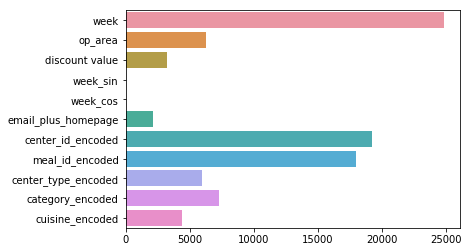

In [163]:
#feature importance curve
sns.barplot(estimator.feature_importances_, x_train.columns)
plt.show()

In [164]:
test=test_data.drop(['id', 'center_id','checkout_price','city_region_encoded',  'base_price', 'meal_id','center_type', 'category', 'cuisine','emailer_for_promotion', 'homepage_featured', 'city_code', 'region_code','city_region','discount percent','discount(yes/no)','checkout_price_transformed', 'base_price_transformed'],axis=1)

In [165]:
test["num_orders_log1p"] = estimator.predict(test)
test["num_orders"] = np.expm1(test["num_orders_log1p"])

In [166]:
test.to_csv("Submission3.csv")